# Data Mining Project: Jigsaw Rate Severity of Toxic Comments 
Kaggle-Id: pondini  
Scores on leaderboard:  
Kaggle Public Score: 0.83226 | Kaggle Private Score: 0.79678

Best Score: Public: 0.83150 | Private: 0.79740

There were also few public scores >84% but clearly worse on the private leaderboard (<78.2%).

Notice: In Jupyter Lab you can navigate with hyperlinks to the chapters/subsections. With [↑](#Overview) you can always come back to the overview. 

## Overview

1. [Imports & Installation](#1.-Imports-&-Installation-↑)
    * 1.1 [Install](#1.1-Install-↑)
    * 1.2 [Imports](#1.2-Imports-↑)
1. [Constants](#2.-Constants-↑)
1. [Helper Functions](#3.-Helper-Functions-↑)
    * 3.1 [Preprocessing](#3.1\)-Preprocessing-↑)
1. [Data Analytics](#4.-Data-Analytics-↑)
1. [Preprocessing](#5.-Preprocessing-↑)
1. [Final Solution](#6.-Final-Solution-↑)
    * 6.1 [Lead to the final solution](#6.1-Lead-to-the-final-solution-↑)
    * 6.2 [KFold: TfidfVectorizer + Ridge + LGBMRegressor](#6.2-KFold:-TfidfVectorizer-+-Ridge-+-LGBMRegressor-↑) 
    * 6.3 [BERT Model](#6.3-BERT-Model-↑)
    * 6.4 [Validate Model](#6.4-Validate-Model-↑)
    * 6.5 [Approaches Ensemble](#6.5-Approaches-Ensemble-↑)
    * 6.6 [Further evaluation of the models](#6.6-Further-evaluation-of-the-models-↑)
1. [Appendix](#7.-Appendix-↑)
    1. [Baseline Solution](#A\)-Baseline-solution-↑)
    1. [TF + Ridge + LGBMRegressor](#B\)-TF-+-Ridge-+-LGBMRegressor-↑)
    1. [ktrain BERT](#C\)-ktrain-BERT-↑)
    1. [Tensorflow BERT: RoBERTa](#D\)-Tensorflow-BERT:-RoBERTa-↑)
    1. [Multilingual dataset linear regression](#E\)-Multilingual-dataset-linear-regression-↑)
    1. [KFold + XLNet](#F\)-KFold-+-XLNet-↑)
1. [Outlook](#8.-Outlook-↑)
    * 8.1 [Normal Classification](#8.1\)-Normal-Classification-↑)
    * 8.2 [Lemmatizing and Streaming](#8.2\)-Lemmatizing-and-Stemming-↑)
    * 8.3 [Combine more approaches](#8.3\)-Combine-more-approaches-↑)
    * 8.4 [Hyperparameter tunin](#8.4\)-Hyperparameter-tuning-↑)
    * 8.5 [Use different models](#8.5\)-Use-different-models-↑)
    * 8.6 [Add Features](#8.6\)-Add-Features-↑)
    * 8.7 [Vectorizer](#8.7\)-Vectorizer-↑)
    * 8.8 [Find the best seed](#8.8\)-Find-the-best-seed-↑)
1. [Sources](#9.-Sources-↑)
    

## 1. Imports & Installation [↑](#Overview)
### 1.1 Install [↑](#Overview)
Execute this cell if necessary.

In [1]:
#!pip install ktrain
#!pip install torch

### 1.2 Imports [↑](#Overview)

In [2]:
import gc
import random

import pandas as pd
import numpy as np
from math import ceil

from wordcloud import WordCloud
import io
import requests

import gensim
from nltk.corpus import stopwords
import nltk
stoplist=stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

import re

from collections import defaultdict
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.compat.v1.keras.initializers import Constant

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import TFRobertaModel, RobertaTokenizer, RobertaConfig, AutoTokenizer, AutoModel, TFAutoModel

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

import eli5

#### ktrain ####
# from ktrain import text
# import ktrain

import h5py

from scipy.stats import rankdata

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## 2. Constants [↑](#Overview)
Declare some constants

Set seed for replication

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Tried different weights for toxic types:

| Type | a) | b) | c) |
| --- | :-: | :-: | :-: |
| toxic | 1 | 0.32 | 1 |
| severe_toxic | 2 | 1.5 | 1.5 |
| obscene | 2 | 0.16 | 1 |
| threat | 3 | 1.5 | 1 |
| insult | 1 | 0.64 | 1 |
| identity_hate | 2 | 1.5 | 1 |

Variant b scored the best results in tests. Tested with basic linear regression models. Appendix: B) TF + Ridge + LGBMRegressor

| Variant | #tests | Ø validation accuracy score in % | best lb score |
| :-: | :-: | :-: | :-: |
| a) | 5 | 66.54 | 82.1 |
| b) | 5 | 67.89 | 84.1 |
| c) | 1 | 65.92 | - |

In [4]:
# Toxic Classes
TOXICITY_TYPES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Weight the several toxic classes
# Order: Toxic, Severe Toxic, Obscene, Threat, Insult, Identity Hate
# LABEL_WEIGHTS = [1, 2, 2, 3, 1, 2]

# LABEL_WEIGHTS = [1, 1.5, 1, 1, 1, 1]

# New label weights. Scored a way better result than the old weights.
LABEL_WEIGHTS = [0.32, 1.5, 0.16, 1.5, 0.64, 1.5]

# Set Seed
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

## 3. Helper Functions [↑](#Overview)
### 3.1) Preprocessing [↑](#Overview)
Based on the data analytics, the preprocessing methods are defined first

In [5]:
def preprocess_text(df, col, remove_stopwords=True, analytics_df=False):
    # Replace a few short forms with the corresponding long forms
    # See: https://www.englisch-hilfen.de/grammar/kurzformen.htm
    df[col].replace(to_replace=r'\'ve', value=' have ', inplace=True, regex=True)
    df[col].replace(to_replace=r'can\'t', value=' cannot ', inplace=True, regex=True)
    df[col].replace(to_replace=r'won\'t', value=' will not ', inplace=True, regex=True)
    df[col].replace(to_replace=r'shan\'t', value=' shall not ', inplace=True, regex=True)
    df[col].replace(to_replace=r'ain\'t', value=' am not ', inplace=True, regex=True)
    df[col].replace(to_replace=r'n\'t', value=' not ', inplace=True, regex=True)
    df[col].replace(to_replace=r'\'m', value=' am ', inplace=True, regex=True)
    df[col].replace(to_replace=r'\'re', value=' are ', inplace=True, regex=True)
    df[col].replace(to_replace=r'\'d', value=' would ', inplace=True, regex=True)
    df[col].replace(to_replace=r'\'ll', value=' will ', inplace=True, regex=True)

    # Remove punctuations and numbers
    df[col].replace(to_replace='[^a-zA-Z]', value=' ', inplace=True, regex=True)

    # Single character removal
    df[col] = df[col].apply(lambda sen: ' '.join([w for w in sen.split() if len(w)>1]))

    # Removing multiple spaces
    df[col].replace(to_replace=r'\s+', value=' ', inplace=True, regex=True)

    if remove_stopwords:
        df[col] = df[col].apply(lambda sen: " ".join([word for word in nltk.tokenize.word_tokenize(sen) if word.lower() not in stoplist]))


    # Lowercase all words for analytics purposes
    if analytics_df:
        df[col]=df[col].str.lower()

    return df

## 4. Data Analytics [↑](#Overview)

In [6]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')

# create a copy for analytics
data = train.copy()

data.shape

(159571, 8)

In [7]:
data = preprocess_text(data, "comment_text", False, True)

In [8]:
data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  explanation why the edits made under my userna...      0   
1  000103f0d9cfb60f  aww he matches this background colour am seemi...      0   
2  000113f07ec002fd  hey man am really not trying to edit war it ju...      0   
3  0001b41b1c6bb37e  more cannot make any real suggestions on impro...      0   
4  0001d958c54c6e35  you sir are my hero any chance you remember wh...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [9]:
for comment_type in TOXICITY_TYPES:
    count = data.loc[data[comment_type]==1, [comment_type]].count()[comment_type]
    
    # Python version to old 
#     print(f'{comment_type=}:')
#     print(f'{count=}')

    print(f'comment_type={comment_type}:')
    print(f'count={count}')
    display(data.loc[data[comment_type]==1, ["comment_text", comment_type]].sample(10))

comment_type=toxic:
count=15294


comment_text  toxic
54995                                   hi wanna rape you      1
22018   terrorize will terrorise you for as long as yo...      1
9074    being blocked so that your idea of mediation i...      1
40050          editing wikipedia fuck you you anal rapist      1
132307  so the fact that the us govt wants to put some...      1
66901     leave our country we do not want you arabs here      1
54769   hi the greek pages are disgrace the demographi...      1
64911   you stupid fat bastard why did you censor the ...      1
103630                          becouse no one gives shit      1
47179        fag stop reverting my edits or will kill you      1

comment_type=severe_toxic:
count=1595


comment_text  severe_toxic
136532  fuck you stupid cunt stay in the kitchen where...             1
143186  dat chick omg didnt vandalise nuffink yh just ...             1
16022   bitch asshole motherfucker go fuck ur mothers ...             1
16959                               you like to be fucked             1
91884   hey telly fuck you too ca not you morons under...             1
155403                               re dead motherfucker             1
156111  californiaalibaba is bitch go fuck yourself yo...             1
15769        hello will you suck my dick for please reply             1
157672                             you are fucking retard             1
93791           hey you are fucking cunt go kill yourself             1

comment_type=obscene:
count=8449


comment_text  obscene
125430  darkwind stick it up your arse you offensive w...        1
79596   this culture allows people to hold their wives...        1
98062   litter act sect is shit try qld act with amend...        1
125285  ok let me say one thing fuck you all fuck you ...        1
103956  block milboreone and huon fuck you but need yo...        1
134219                               you you stupid bitch        1
144369  first off avril lavagflaps is suck ass singer ...        1
100891              pure bullshit the dissident aggressor        1
5973                                   your fucking bitch        1
95249   npov would change this crap but metalcore is f...        1

comment_type=threat:
count=478


comment_text  threat
115754  hate armenia and all your dumb allies you do n...       1
60015   supertr ll will live forever if you don respec...       1
123794  she is motherfucker will block you motherfucke...       1
130182  will kill you will blow up your house and kill...       1
43801   miners day thanks for deleting it fuck bag not...       1
156084                         die you washed up has been       1
71866   will find you in real life and kill you will f...       1
7299    you are stupid cunt fuck you dumb arse your mu...       1
75802   will net left harassing you am the same ip who...       1
96896   because of your censorship and abuse of oversi...       1

comment_type=insult:
count=7877


comment_text  insult
90131   complain and more complains thats what re good...       1
5919    delete you delete vandalist pages you sick sic...       1
158695  jfdwolff your profound lack of wisdom is no cr...       1
61156                            yo you are one ugly dude       1
38673                      warning user is flaming faggot       1
46783   indian pov pushers seems like some tag teaming...       1
40352   you whiny sissy coward hacker trolls and freak...       1
14720                         perhaps perhaps che was pig       1
105663  wow way to call me liar when you have no knowl...       1
52085   go fuck yourself go fuck yourself you irritati...       1

comment_type=identity_hate:
count=1405


comment_text  identity_hate
55160   anyone who supports this is fucking sick men a...              1
158951       fuck you barack obama is muslim he sucks ass              1
133967  bitch nobody cares about your myspace you ugly...              1
16390   hey hey faggot are you dead or are you watchin...              1
30246   you dumb mother fucking nigger lover stop dele...              1
12241   re knowledge generation bureau why the fuck ar...              1
79281   pakis one of the most ugliest individuals of t...              1
116252            hey your gay nigger mother fucking cunt              1
35183                     fuck off your piece of shit jew              1
101695  dirty everywhere it stinks and smells bad thes...              1

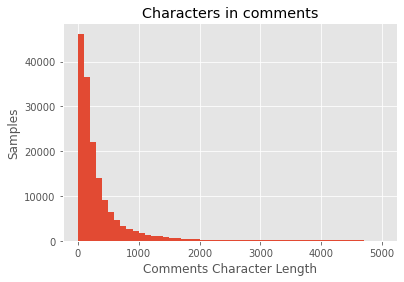

In [10]:
plt.hist(data['comment_text'].str.len(), bins=50)
plt.ylabel('Samples')
plt.xlabel('Comments Character Length')
plt.title('Characters in comments')
plt.show()

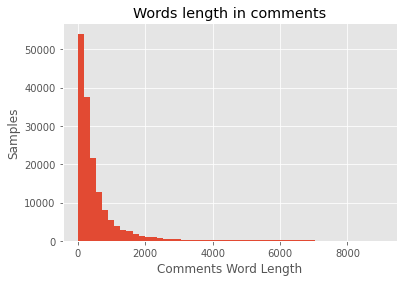

In [11]:
plt.hist(data['comment_text'].str.split().map(lambda x: len(str(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Comments Word Length')
plt.title('Words length in comments')
plt.show()

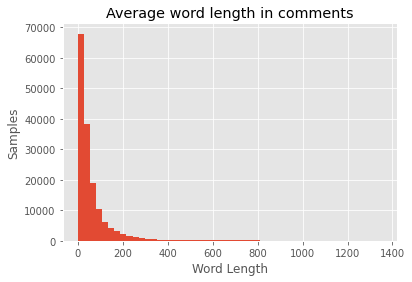

In [12]:
plt.hist(data['comment_text'].str.split().apply(lambda x: x if isinstance(x, list) else []).map(lambda x: np.mean(len(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Word Length')
plt.title('Average word length in comments')
plt.show()

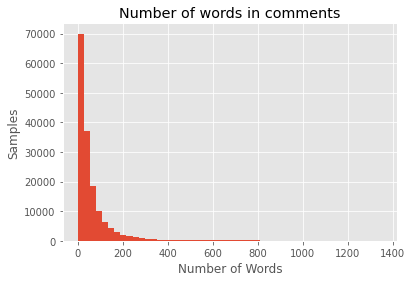

In [13]:
plt.hist(data['comment_text'].str.split().map(lambda x: len(str(x).split(' '))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Number of Words')
plt.title('Number of words in comments')
plt.show()

Most used stopwords

In [14]:
comment_text= data['comment_text'].str.split().apply(lambda x: x if isinstance(x, list) else [])
comment_text=comment_text.values.tolist()
analytics_corpus=[word for i in comment_text for word in i]

dic=defaultdict(int)
for word in analytics_corpus:
    if word in stoplist:
        dic[word]+=1

keys = [x[0] for x in sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]]
values = [x[1] for x in sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]]

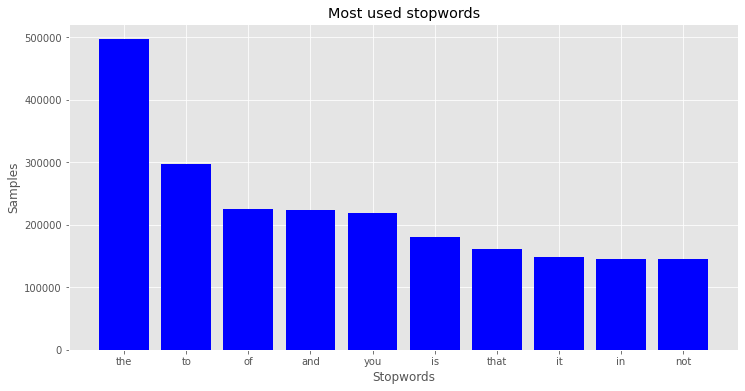

In [15]:
plt.figure(figsize=(12,6))
plt.bar(keys, values, align='center', color='b')
plt.ylabel('Samples')
plt.xlabel('Stopwords')
plt.title('Most used stopwords')
plt.show()

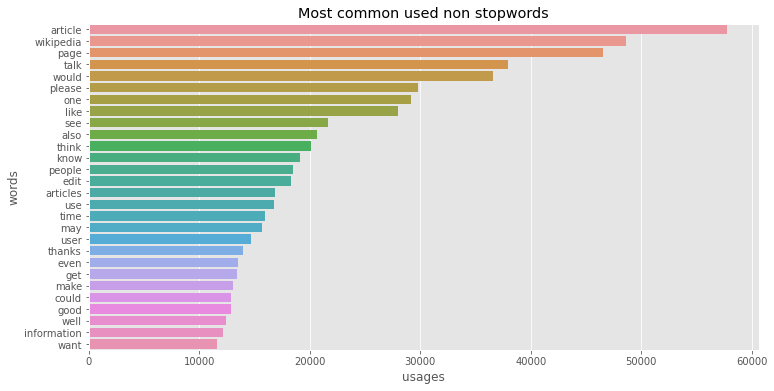

In [16]:
plt.figure(figsize=(12,6))
counter=Counter(analytics_corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:100]:
    if word not in stoplist:
        x.append(word)
        y.append(count)

ax = sns.barplot(x=y,y=x)
ax.set_title('Most common used non stopwords')
ax.set_ylabel('words')
ax.set_xlabel('usages')
plt.show()

#### Most used words in as toxic marked text
Find the most used words/insults in toxic text

In [17]:
condition = (data["toxic"]==1) | (data["severe_toxic"]==1) | (data["obscene"]==1) | (data["threat"]==1) | (data["insult"]==1) | (data["identity_hate"]==1)

In [18]:
data.loc[condition, ["comment_text"]]

comment_text
6            cocksucker before you piss around on my work
12      hey what is it talk what is it an exclusive gr...
16      bye do not look come or think of comming back ...
42      you are gay or antisemmitian archangel white t...
43                 fuck your filthy mother in the ass dry
...                                                   ...
159494  our previous conversation you fucking shit eat...
159514                    you are mischievious pubic hair
159541  your absurd edits your absurd edits on great w...
159546  hey listen do not you ever delete my edits eve...
159554  and am going to keep posting the stuff deleted...

[16225 rows x 1 columns]

In [19]:
insults= data.loc[condition, ["comment_text"]]["comment_text"].str.split().apply(lambda x: x if isinstance(x, list) else [])
insults=insults.values.tolist()
insult_corpus=[word for i in insults for word in i]

insult_dic=defaultdict(int)
for word in insult_corpus:
    if word not in stoplist and word not in x:
        insult_dic[word]+=1

insult_keys = [x[0] for x in sorted(insult_dic.items(), key=lambda x: x[1], reverse=True)[:10]]
insult_values = [x[1] for x in sorted(insult_dic.items(), key=lambda x: x[1], reverse=True)[:10]]

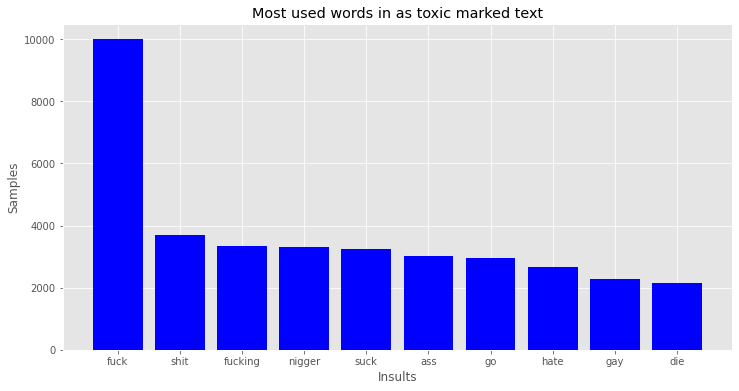

In [20]:
plt.figure(figsize=(12,6))
plt.bar(insult_keys, insult_values, align='center', color='b')
plt.ylabel('Samples')
plt.xlabel('Insults')
plt.title('Most used words in as toxic marked text')
plt.show()

#### Wordcloud

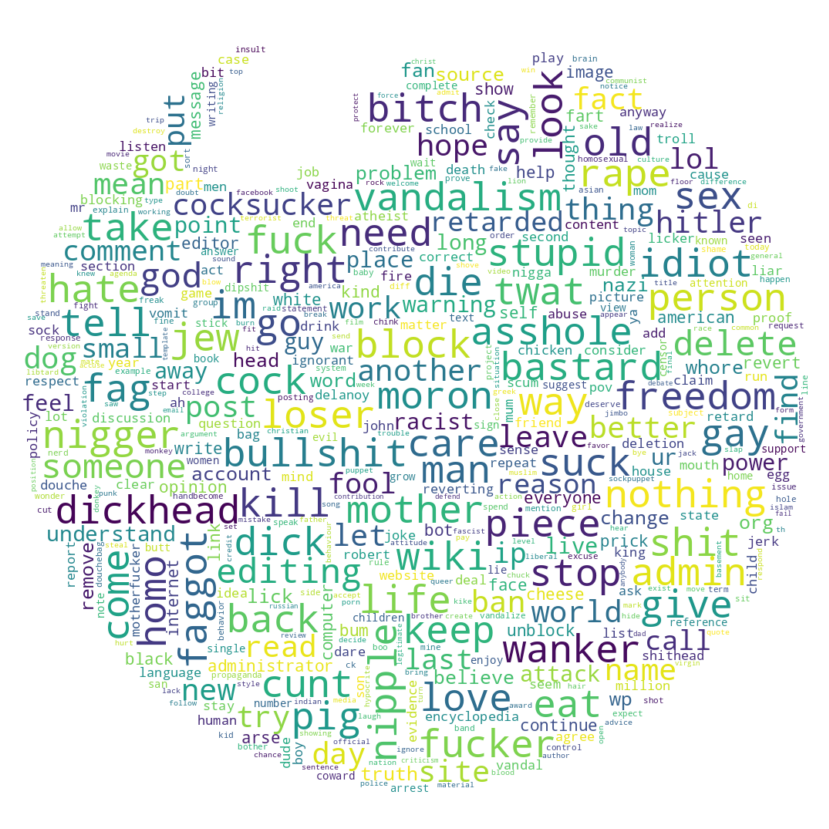

In [21]:
import PIL
from wordcloud import WordCloud



mask = np.array(
    PIL.Image.open(
        io.BytesIO(
            requests.get("").content
        )
    )
)

wc = WordCloud(max_font_size=50, background_color="white", max_words=500, mask=mask)

wc.generate(' '.join([x[0] for x in sorted(insult_dic.items(), key=lambda x: x[1], reverse=True)]))

plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Check balance between toxic and non-toxic comments
Dataset looks pretty unbalanced. There are 90% non-toxic and 10% toxic comments. Maybe balance the dataset?

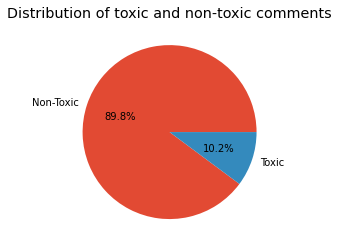

In [22]:
labels = ["Non-Toxic", "Toxic"]
somehow_toxic = len(data[data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0])
non_toxic = len(data[data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) == 0])
x = [non_toxic, somehow_toxic]

plt.pie(x=x, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of toxic and non-toxic comments")
plt.show()

#### Distribution toxicness

Unweighted

In [23]:
data["y_unweighted"] = (data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)).astype(int)

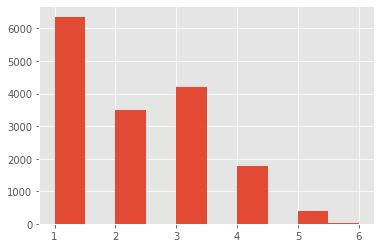

In [24]:
data[data["y_unweighted"] > 0]["y_unweighted"].hist()
plt.show()

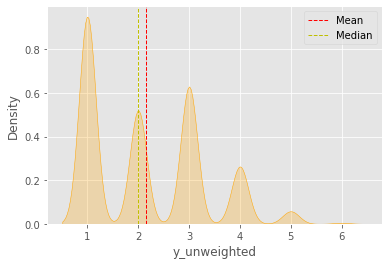

In [25]:
sns.kdeplot(data[data['y_unweighted'] > 0]['y_unweighted'], shade = True, color = 'orange')
plt.axvline(data[data['y_unweighted'] > 0]['y_unweighted'].mean(), label = 'Mean', color = 'r', linewidth = 1, linestyle = '--')
plt.axvline(data[data['y_unweighted'] > 0]['y_unweighted'].median(), label = 'Median', color = 'y', linewidth = 1, linestyle = '--')
plt.legend();

Weighted

In [26]:
data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] * LABEL_WEIGHTS

In [27]:
data["y"] = (data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)).astype(int)
data["y"] = data["y"]/data["y"].max()

data.drop(columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], inplace=True)

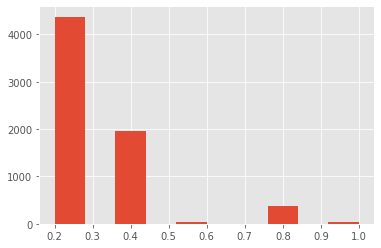

In [28]:
data[data["y"] > 0]["y"].hist()
plt.show()

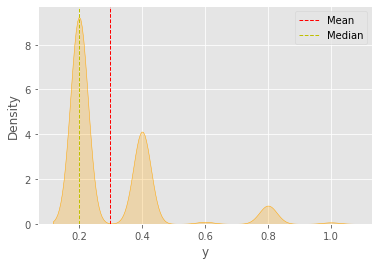

In [29]:
sns.kdeplot(data[data['y'] > 0]['y'], shade = True, color = 'orange')
plt.axvline(data[data['y'] > 0]['y'].mean(), label = 'Mean', color = 'r', linewidth = 1, linestyle = '--')
plt.axvline(data[data['y'] > 0]['y'].median(), label = 'Median', color = 'y', linewidth = 1, linestyle = '--')
plt.legend();

Are there common data in train and validate data?

In [30]:
validate = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
validate = preprocess_text(validate, "less_toxic", False, True)
validate = preprocess_text(validate, "more_toxic", False, True)

In [31]:
in_common_less_toxic = data.comment_text.isin(validate.less_toxic)
in_common_more_toxic = data.comment_text.isin(validate.more_toxic)

in_common = in_common_less_toxic | in_common_more_toxic

In [32]:
data[in_common]

comment_text  y_unweighted    y
6            cocksucker before you piss around on my work             4  0.4
7       your vandalism to the matt shirvington article...             0  0.0
42      you are gay or antisemmitian archangel white t...             4  0.4
43                 fuck your filthy mother in the ass dry             3  0.2
47      in other words you are too lazy to actually po...             0  0.0
...                                                   ...           ...  ...
159457  my user page thanks for reverting the vandalis...             0  0.0
159490  the wwe raw guest host initiative was introduc...             0  0.0
159493                              fucking faggot lolwat             3  0.2
159514                    you are mischievious pubic hair             2  0.0
159517  you have got no call to start attacking me ad ...             0  0.0

[14390 rows x 3 columns]

In [33]:
data[in_common_less_toxic]

comment_text  y_unweighted    y
7       your vandalism to the matt shirvington article...             0  0.0
47      in other words you are too lazy to actually po...             0  0.0
48      as for your claims of stalking that is absolut...             0  0.0
56      tony sidaway is obviously fistfuckee he loves ...             3  0.2
58      my band page deletion you thought was gone del...             2  0.0
...                                                   ...           ...  ...
159411  fat piece of shit you obese piece of shit thou...             3  0.2
159452  am really sorry about your relatives but any r...             0  0.0
159457  my user page thanks for reverting the vandalis...             0  0.0
159490  the wwe raw guest host initiative was introduc...             0  0.0
159514                    you are mischievious pubic hair             2  0.0

[11663 rows x 3 columns]

In [34]:
data[in_common_more_toxic]

comment_text  y_unweighted    y
6            cocksucker before you piss around on my work             4  0.4
42      you are gay or antisemmitian archangel white t...             4  0.4
43                 fuck your filthy mother in the ass dry             3  0.2
48      as for your claims of stalking that is absolut...             0  0.0
56      tony sidaway is obviously fistfuckee he loves ...             3  0.2
...                                                   ...           ...  ...
159452  am really sorry about your relatives but any r...             0  0.0
159490  the wwe raw guest host initiative was introduc...             0  0.0
159493                              fucking faggot lolwat             3  0.2
159514                    you are mischievious pubic hair             2  0.0
159517  you have got no call to start attacking me ad ...             0  0.0

[11810 rows x 3 columns]

Can maybe removed later from train data?

##### Analyze validation data

Remove stopwords

In [35]:
def n_grams(text, n_gram=1):
    token = [word for word in nltk.word_tokenize(text) if word not in stoplist]
    ngrams = zip(*[token[i:] for i in range(n_gram)])

    return [' '.join(ngram) for ngram in ngrams]

In [36]:
def print_n_grams(ngram_list, n=20):
    if len(ngram_list) > 2:
        return

    fig, axes = plt.subplots(nrows=ceil(len(ngram_list) / 2), ncols=(2 if len(ngram_list) > 1 else 1), figsize=(20, n//2))
    colors = ['green','red', 'orange', 'blue', 'magenta', 'pink', 'gold', 'brown', 'deepskyblue']

    for index, plots in enumerate(ngram_list):
        words, counts = zip(*Counter(plots).most_common()[:n])
        sns.barplot(y=list(words)[:n], x=list(counts)[:n], color=random.choice(colors), ax=axes if len(ngram_list) < 2 else axes[index])


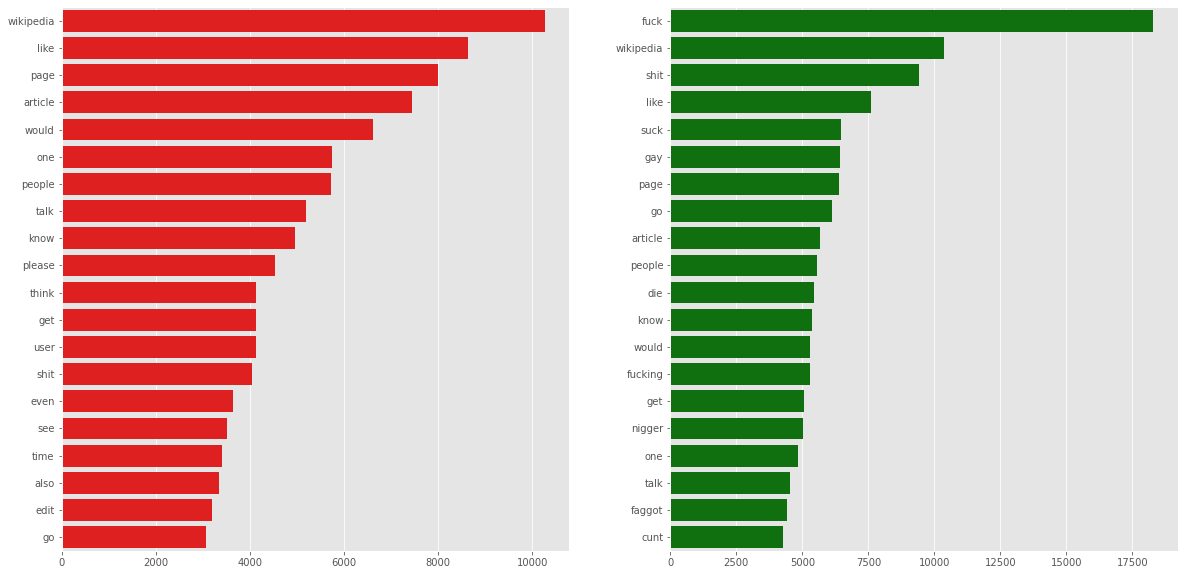

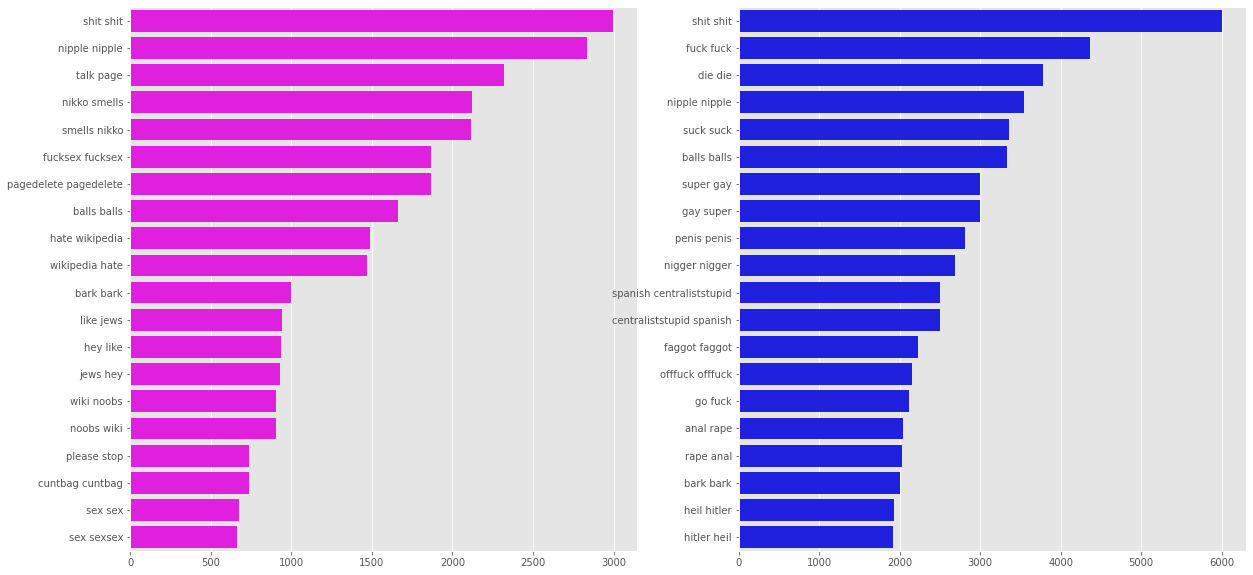

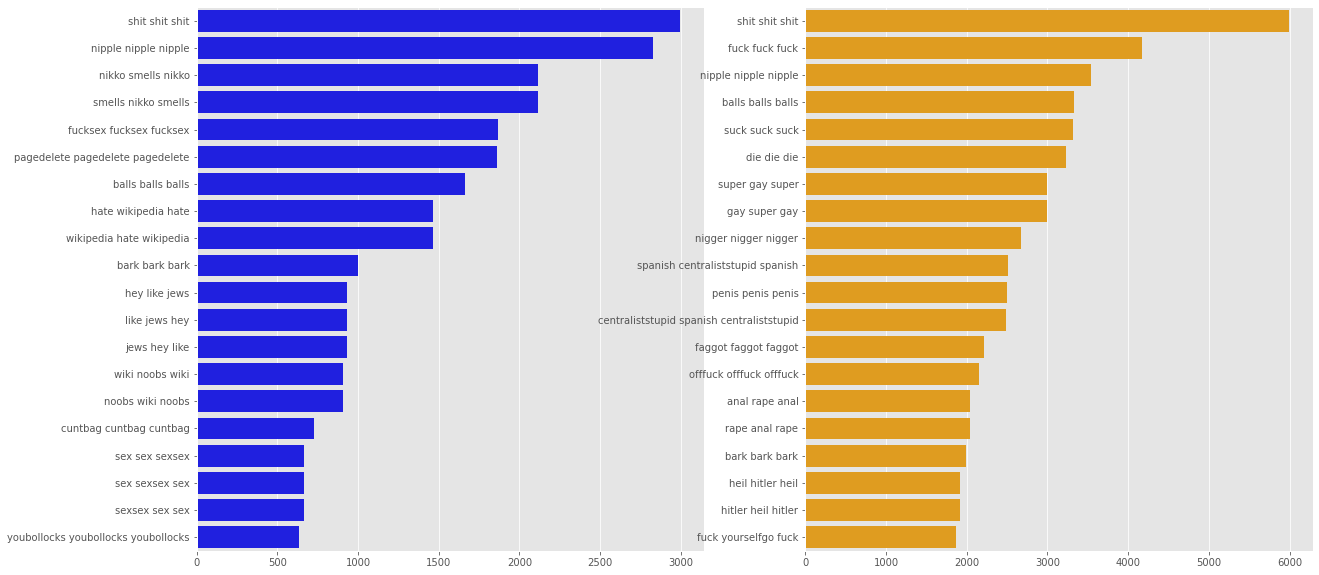

In [37]:
for i in range(1, 4, 1):
    less = []
    for text in validate["less_toxic"]:
        less += [words for words in n_grams(text, i)]

    more = []
    for text in validate["more_toxic"]:
        more += [words for words in n_grams(text, i)]

    print_n_grams([less, more])

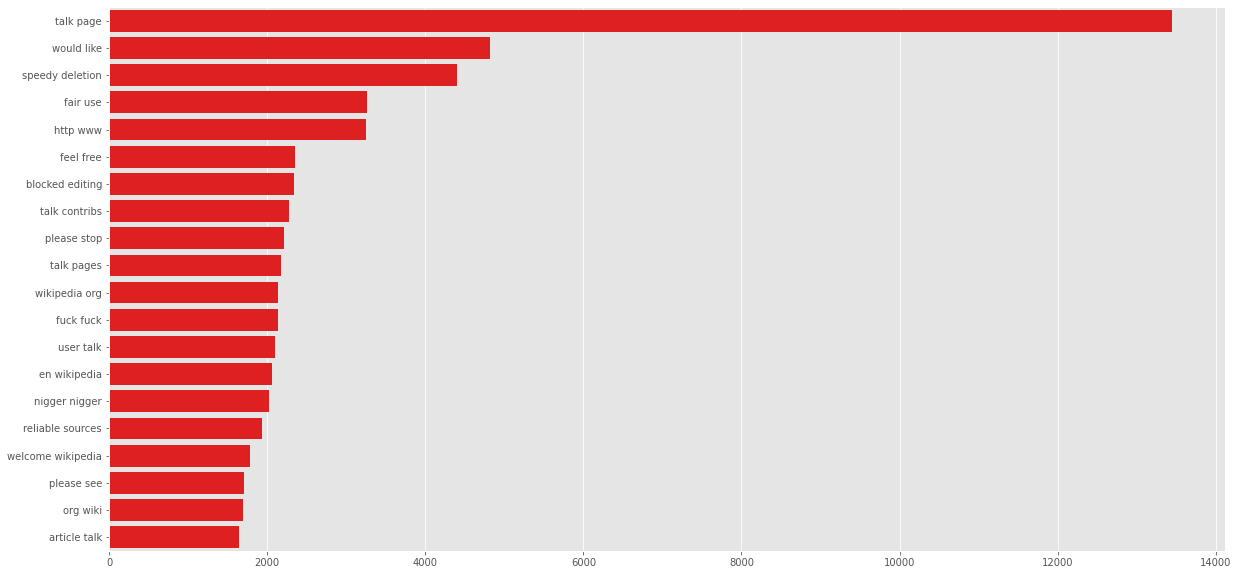

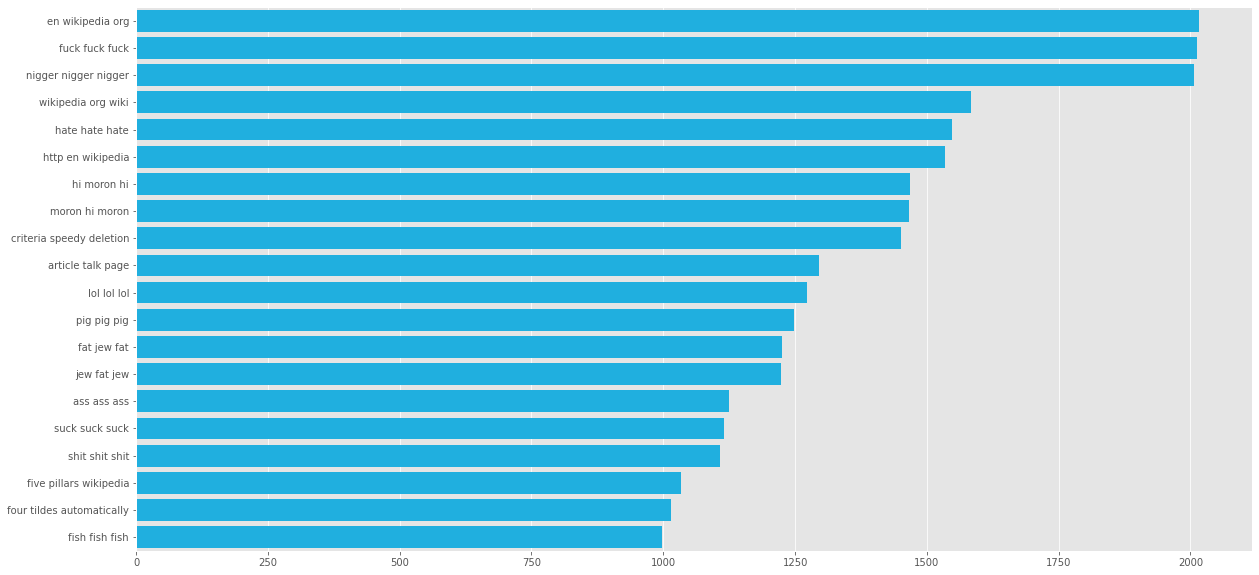

In [38]:
for i in range(2, 4, 1):
    normal = []
    for text in data["comment_text"]:
        normal += [words for words in n_grams(text, i)]

    print_n_grams([normal])

Delete data

In [39]:
del data, validate, in_common, in_common_less_toxic, in_common_more_toxic
gc.collect()

77239

Previously it was shwon that validation data and training data contain overlaps. Therefore, it is checked whether the scoring data also occur in other data sets

In [40]:
score_df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
validate_df = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
classification_df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")

in_common_classification = classification_df.comment_text.isin(score_df.text)
classification_df[in_common_classification]

id                                       comment_text  \
63      002746baedcdff10  "\n\n""Christian arabs""\nHi. Could you please...   
73      002c9cccf2f1d05b  "\n Ambiguous ? \nSo Mabuska Irish can mean mo...   
86      0036621e4c7e10b5  Would you both shut up, you don't run wikipedi...   
176     006b94add72ed61c  I think that your a Fagget get a oife and burn...   
183     006f2c1459f3b6b1  "== new ==\n\n{{userbox \n TABTAB| id =  \n TA...   
...                  ...                                                ...   
159317  fbff29b49a54f513  "\n\n atomic49er  \n\nUser atomic49er\n\nSince...   
159336  fc3efa2f6f025f6d  Oh, fuck off. The pansy Jew would just whine a...   
159452  fddff1cdedcce539  "\nI am really sorry about your relatives, but...   
159490  fee7f29a7e10ce6f  "\n\n""The WWE Raw guest host initiative was i...   
159517  ff4eb629bb10208f  "\nYou've got no call to start attacking me ad...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
63          0             0        0       0       0              0  
73          0             0        0       0       0              0  
86          1             0        0       0       1              0  
176         1             0        1       1       1              1  
183         0             0        0       0       0              0  
...       ...           ...      ...     ...     ...            ...  
159317      0             0        0       0       0              0  
159336      1             0        1       0       1              1  
159452      0             0        0       0       0              0  
159490      0             0        0       0       0              0  
159517      0             0        0       0       0              0  

[4031 rows x 8 columns]

In [41]:
validation = pd.DataFrame(columns={"text"})
validation["text"] = pd.concat([validate_df["less_toxic"], validate_df["more_toxic"]], ignore_index=True).drop_duplicates()

in_common_validation = validation.text.isin(score_df.text)
validation[in_common_validation]

text
0                This article sucks \n\nwoo woo wooooooo
1      "And yes, people should recognize that but the...
2       Western Media?\n\nYup, because every crime in...
3      And you removed it! You numbskull! I don't car...
4       smelly vagina \n\nBluerasberry why don't you ...
...                                                  ...
60124  Surly as this is my own user talk page i can s...
60147                  Fuck you Pavel Vozenilek you fag.
60160  ":::fuck you animal! remember this shit yourse...
60190      Some Say She is a little mothyer fukin bitchy
60213                       Piss off you slant eyed-gook

[7537 rows x 1 columns]

There does seem to be overlap between the data sets. These overlaps could either be removed or need to be dealt with differently. If the problem is simply accepted without countermeasures, slight overfitting could occur. 

In [42]:
del score_df, validate_df, classification_df, in_common_classification, validation, in_common_validation
gc.collect()

23

## 5. Preprocessing [↑](#Overview)

Give the types of toxicity individual weights

In [43]:
train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] * LABEL_WEIGHTS

Normalize data between 0 to 1 by y values

In [44]:
train["y"] = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)).astype(int)
train["y"] = train["y"]/train["y"].max()

Drop all other columns than comments and y values

In [45]:
train.drop(columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], inplace=True)

Preprocess text

In [46]:
train = preprocess_text(train, "comment_text")

## 6. Final Solution [↑](#Overview)

### 6.1 Lead to the final solution [↑](#Overview)
At first, checked out a baseline solution with a simple lstm with several variations. In the beginning were the best solutions around ~70% in public score. From experience from the last competition in Data Science I knew there are some better models to perform text classification. Especially the BERT models. So the next step was to implement a BERT solution with ktrain. Unfortunately ktrain needs to be installed in the Kaggle Environment. Since there's no internet allowed and there's no model in a dataset available, BERT with ktrain isn't a option anymore. For this reason a pretrained Roberta Model was used from the Kaggle Datasets: [Roberta Base](https://www.kaggle.com/abhishek/roberta-base). This solution didn't performed well in the beginning. So the next approach was to read some discussion threads, e.g. [Why do Linear Models Outperform Deep Models?](https://www.kaggle.com/c/jigsaw-toxic-severity-rating/discussion/295624), and start to try linear regression models. Ridge Regression works in this use case very well. It prevents overfitting, but it's not very useful in case of exorbitantly high number of features. [[²](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/)] In this use case these numbers aren't reached, on the contrary, it performs very, very quickly. Ridge Regression works well even in presence of highly correlated features. Ridge + LGBMRegressor with TfidfVectorizer as word embedding performed in the first pass very well: ~0.813 public score in the leaderboard. The validation with validation data shows a slightly increase by combining the models. In the Appendix section under "TF + Ridge + LGBMRegressor" are also some more linear regression models listed.

Since the public leaderboard is calculated with only 5% of the data, it is probably better to use something like cross validation. Either KFold from sklearn can be used or a custom fold method is written. Here a separate fold method was written. In addition, a second dataset was used: [Ruddit Jigsaw Dataset](https://www.kaggle.com/rajkumarl/ruddit-jigsaw-dataset). More possible datasets could be found in this thread: [Best Training Datasets](https://www.kaggle.com/c/jigsaw-toxic-severity-rating/discussion/297515). Creating folds is inspired by: [Jigsaw Ensemble [0.864]](https://www.kaggle.com/icaram/jigsaw-ensemble-0-864) and [Jigsaw CV strategy](https://www.kaggle.com/its7171/jigsaw-cv-strategy). In the appendix "E) Multilingual dataset linear regression" can be an approach with another dataset with a smaller data anylsis found. There was much more data in this data set. Therefore, the execution time was significantly longer. Alas, the results were also very sobering: none of the four runs came close to the 80% lb score, even though the validation accuaracy was very decent. Edit: None of the runs were convincing after the competition either. There were also no good results in the Private Leaderboard.

Coming back to a neural network, a basic approach would be to use the 2018 Classification data. This approach was implemented in the earlier RoBERTa Base model with tensorflow. Here, the data was used to train and the given validation data was used to evaluate the model. The [Everything you need related to BERT in one place](https://www.kaggle.com/c/jigsaw-toxic-severity-rating/discussion/286355) Thread helped a lot to build up another model. In this case, the XLNet was implemented. A pre-trained model can also be found on Kaggle. The XLNet directly performed a way better than the previous BERT model. The implementation and training integration could be found in the appendix "F) KFold + XLNet".
Another approach would be to use the given validation data for training purposes. This approach has already been implemented by another Data Scientist as part of the Kaggle competition. In this implementation approach, several models were trained and their weights were stored. The RoBERTa model of the final solution is based on this notebook with a pretrained RoBERTa model on the jigsaw toxic data: [[Pytorch + W&B] Jigsaw Starter](https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter). This solution scored a way better than the BERT model and XLNet model before. In combination with KFold it reached a score of 0.79740 on the private leaderboard. Unfortunately this score wasn't selected for the leaderboard. The second best approach, which was selected, scored 0.79678 on the private leaderboard. This approach also used RoBERTA base model + KFold with preprocessed and not preprocessed data. In the appendix "8.1) Normal classification" a few more thoughts on different approaches are given. 

However, the scores of all approaches need to be considered with caution. A small data comparison showed, a large part of the texts to be evaluated can already be found in the validation data of the current competition or classification data of the previous competition. Therefore, using the Ruddit data is a good option, even if the models trained with it show a slight bias. 
Nevertheless, I am glad about my results in the competition. I've learned a lot and I am happy about the 190th place on the private leaderboard and the associated bronze medal.  

### 6.2 KFold: TfidfVectorizer + Ridge + LGBMRegressor [↑](#Overview)

In [47]:
ruddit = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
ruddit.drop(columns=["post_id", "comment_id", "url"], inplace=True)
ruddit.rename(columns={"txt": "comment_text", "offensiveness_score": "y"}, inplace=True)

Scale data from 0 to 1

In [48]:
print(f'Old range: Min: {ruddit["y"].min()} ; Max: {ruddit["y"].max()}')
# Rerange y range from 0 to 1
ruddit["y"] = (ruddit["y"] - ruddit["y"].min()) / (ruddit["y"].max() - ruddit["y"].min())
print(f'New range: Min: {ruddit["y"].min()} ; Max: {ruddit["y"].max()}')

Old range: Min: -0.889 ; Max: 0.979
New range: Min: 0.0 ; Max: 1.0


Plot distribution

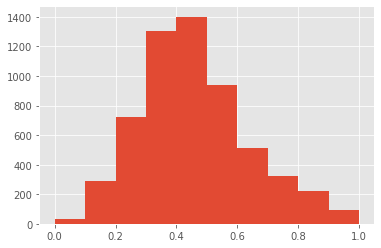

In [49]:
ruddit["y"].hist()
plt.show()

Create Dataframes for folded data:
- Fold data without preprocessing
- Fold data with preprocessing
- Ruddit fold data without preprocessing
- Ruddit fold data with preprocessing

In [50]:
columns=["comment_text", "y", "fold"]

fold_data = pd.DataFrame(columns=columns)
fold_clean_data = pd.DataFrame(columns=columns)
fold_ruddit = pd.DataFrame(columns=columns)
fold_clean_ruddit = pd.DataFrame(columns=columns)

Fold Hyperparameter

In [51]:
n_folds = 7
frac = 0.4
factor = 1.25

Create evaluation data for later

In [52]:
# define random state
rnd_state = 123

# get samples from toxic and non toxic data set
toxic_eval = train[train["y"] > 0].sample(n=182, random_state=rnd_state)
non_toxic_eval = train[train["y"] == 0].sample(n=182, random_state=rnd_state)

# create evaluation dataframe
eval_data = pd.concat([toxic_eval, non_toxic_eval])
# create copy and preprocess text
eval_clean_data = preprocess_text(eval_data.copy(), "comment_text")

# drop overlapping data rows
train.drop(eval_data.index, inplace=True)

# delete unnecessary variables
del rnd_state, toxic_eval, non_toxic_eval

Create folds

In [53]:
for fold in range(n_folds):
    random_state = 2*fold+1

    ### Normal Data ###
    toxic_part = train[train["y"] > 0].sample(frac=frac, random_state=random_state)
    non_toxic_part = train[train["y"] == 0].sample(n=int(len(toxic_part)*factor), random_state=random_state)

    toxic_clean_part = preprocess_text(train[train["y"] > 0].sample(frac=frac, random_state=random_state), "comment_text")
    non_toxic_clean_part = preprocess_text(train[train["y"] == 0].sample(n=int(len(toxic_part)*factor), random_state=random_state), "comment_text")

    # Get length of toxic and non toxic part
    length = len(toxic_part) + len(non_toxic_part)

    # Shuffle data and append it
    fold_data=fold_data.append(shuffle(pd.concat([toxic_part, non_toxic_part], axis=0), random_state=random_state).assign(fold=np.full(length,fold)))
    fold_clean_data=fold_clean_data.append(shuffle(pd.concat([toxic_clean_part, non_toxic_clean_part], axis=0), random_state=random_state).assign(fold=np.full(length,fold)))

    ### Ruddit Data ###
    # Take whole ruddit data
    ruddit_data = shuffle(ruddit, random_state=random_state).assign(fold=np.full(len(ruddit), fold))
    fold_ruddit = fold_ruddit.append(ruddit_data)
    fold_clean_ruddit = fold_clean_ruddit.append(preprocess_text(ruddit_data, "comment_text"))

Create a list to save the models to evaluate them later

In [54]:
model_evaluation_list = []

Create fitting pipeline

*Note:
In this example the default ridge regression (alpha=1) is used. Various hyperparameters for the model were also tried. Some differences appeared and for a better result the optimal alpha value would have to be found. However, this procedure would cost additional time and is therefore and due limited GPU time not used.

In some trials alpha = 8 showed the best result, in other runs alpha = 5 showed the best result. A dynamic grid search would have return the best ridge regression model. Another approach would be to use more ridge regression models and get the mean value of all of them.

In [55]:
def pred_pipeline(tmp_df, validate_df, to_score_df):
    # Create Vectorizer
    tfvec = TfidfVectorizer(analyzer = 'char_wb', ngram_range = (3,5))
    # Fit Vectorizer on comments and transform them
    tfv = tfvec.fit_transform(tmp_df["comment_text"])

    # Create Ridge Regression
    ridge = Ridge()
    # Fit Ridge Regression on vectorized data
    ridge.fit(tfv, tmp_df["y"])

    # Create LGBM Regressor
    lgbm = LGBMRegressor(objective="regression", n_estimators=1000, random_seed=RANDOM_SEED)
    # Fit LGBM Regressor on vectorized data
    lgbm.fit(tfv, tmp_df["y"])

    # Save models and tfvec for evaluation
    model_evaluation_list.append({
        'tfvec': tfvec,
        'ridge': ridge,
        'lgbm' : lgbm
    })

    # Transform validation and the to scoring comments
    less_comment = tfvec.transform(validate_df['less_toxic'])
    more_comment = tfvec.transform(validate_df['more_toxic'])
    score_comment = tfvec.transform(to_score_df['text'])

    # Predict with Ridge Regressor on validation and to scoring data
    less_ridge = ridge.predict(less_comment)
    more_ridge = ridge.predict(more_comment)
    score_ridge = ridge.predict(score_comment)

    # Predict with LGBM Regressor on validation and to scoring data
    less_lgbm = lgbm.predict(less_comment)
    more_lgbm = lgbm.predict(more_comment)
    score_lgbm = lgbm.predict(score_comment)

    # Combine Regressor predictions
    less_toxic = less_ridge*0.5 + less_lgbm*0.5
    more_toxic = more_ridge*0.5 + more_lgbm*0.5
    score = score_ridge*0.5 + score_lgbm*0.5

    return less_toxic, more_toxic, score

##### Predict & Validate
To validate the models it's possible to use either the leaderboard score or the validation dataset. In the validation data you can find "less toxic" and "more toxic" comments. It can be assumed that "less toxic" comments have a lower score than "more toxic" comments. So you get an accuracy score with this formula: np.mean((a < b)) where a are the predictions of the "less toxic" comments and b are the predictions of the "more toxic" comments.
Validation Accuracy score: np.round(np.mean((a < b)) * 100, 2)  
It is striking that validation accuracy and leaderboard accuracy do not necessarily correlate with each other. In some cases the validation accuracy gets worse than the run before but the leaderboard validation gets better and vice versa. This could be due to the fact that two data sets are compared during validation, but no direct error value is given and thus no concrete classification of the validation takes place. It is possible that two non-toxic comments are compared and the models cannot detect a clear difference, but rank the "less_toxic" marked comment slightly more toxic than the "more_toxic" comment. This could reduce the accuracy of the validation.

In [56]:
# Create Validate, Scoring DataFrames
validate = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
to_score = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

# Create a version with preprocessed comments
validate_clean = validate.copy()
to_score_clean = to_score.copy()

validate_clean = preprocess_text(validate_clean, "less_toxic")
validate_clean = preprocess_text(validate_clean, "more_toxic")
to_score_clean = preprocess_text(to_score_clean, "text")

Create arrays to collect the individual predictions

In [57]:
# Arrays for the predictions of normal data
less_pred = np.zeros((validate.shape[0], n_folds))
more_pred = np.zeros((validate.shape[0], n_folds))
test_pred = np.zeros((to_score.shape[0], n_folds))

In [58]:
# Arrays for the predictions of normal clean data
less_clean_pred = np.zeros((validate_clean.shape[0], n_folds))
more_clean_pred = np.zeros((validate_clean.shape[0], n_folds))
test_clean_pred = np.zeros((to_score_clean.shape[0], n_folds))

In [59]:
# Arrays for the predictions of ruddit data
less_ruddit_pred = np.zeros((validate.shape[0], n_folds))
more_ruddit_pred = np.zeros((validate.shape[0], n_folds))
test_ruddit_pred = np.zeros((to_score.shape[0], n_folds))

In [60]:
# Arrays for the predictions of ruddit clean data
less_ruddit_clean_pred = np.zeros((validate_clean.shape[0], n_folds))
more_ruddit_clean_pred = np.zeros((validate_clean.shape[0], n_folds))
test_ruddit_clean_pred = np.zeros((to_score_clean.shape[0], n_folds))

In [61]:
# Iterate through folds and predict on their data
for fold in range(n_folds):
    ##### Normal Data #####
    tmp = fold_data[fold_data.fold == fold][["comment_text", "y"]]

    less_pred[:,fold], more_pred[:,fold], test_pred[:,fold] = pred_pipeline(tmp, validate, to_score)

    ##### Clean Data ######
    tmp = fold_clean_data[fold_clean_data.fold == fold][["comment_text", "y"]]
    tmp = preprocess_text(tmp, "comment_text")

    less_clean_pred[:,fold], more_clean_pred[:,fold], test_clean_pred[:,fold] = pred_pipeline(tmp, validate_clean, to_score_clean)

    ##### Ruddit Normal #####
    tmp = fold_ruddit[fold_ruddit.fold == fold][["comment_text", "y"]]

    less_ruddit_pred[:,fold], more_ruddit_pred[:,fold], test_ruddit_pred[:,fold] = pred_pipeline(tmp, validate, to_score)

    ##### Ruddit Clean #####
    tmp = fold_clean_ruddit[fold_clean_ruddit.fold == fold][["comment_text", "y"]]
    tmp = preprocess_text(tmp, "comment_text")

    less_ruddit_clean_pred[:,fold], more_ruddit_clean_pred[:,fold], test_ruddit_clean_pred[:,fold] = pred_pipeline(tmp, validate_clean, to_score_clean)


Validate predictions on validation data

In [62]:
less = less_pred.mean(axis=1)
more = more_pred.mean(axis=1)

print(f'Validation accuracy normal Data: {np.round(np.mean(less < more) * 100, 2)}')

clean_less = less_clean_pred.mean(axis=1)
clean_more = more_clean_pred.mean(axis=1)

print(f'Validation accuracy normal clean Data: {np.round(np.mean(clean_less < clean_more) * 100, 2)}')

ruddit_less = less_ruddit_pred.mean(axis=1)
ruddit_more = more_ruddit_pred.mean(axis=1)

print(f'Validation accuracy ruddit Data: {np.round(np.mean(ruddit_less < ruddit_more) * 100, 2)}')

ruddit_clean_less = less_ruddit_clean_pred.mean(axis=1)
ruddit_clean_more = more_ruddit_clean_pred.mean(axis=1)

print(f'Validation accuracy ruddit clean Data: {np.round(np.mean(ruddit_clean_less < ruddit_clean_more) * 100, 2)}')

Validation accuracy normal Data: 66.76
Validation accuracy normal clean Data: 67.13
Validation accuracy ruddit Data: 63.55
Validation accuracy ruddit clean Data: 63.37


Weight the model predictions

In [63]:
weights = []
for i in range(0, 100, 1):
    for j in range(100-i, 0, -1):
        for k in range(100-j-i, 0, -1):
            w_1 = round((i/100), 2)
            w_2 = round((j/100), 2)
            w_3 = round((k/100), 2)
            w_4 = abs(round((1 - w_1 - w_2 - w_3), 2))

            w_less = less*w_1 + clean_less*w_2 + ruddit_less*w_3 + ruddit_clean_less*w_4
            w_more = more*w_1 + clean_more*w_2 + ruddit_more*w_3 + ruddit_clean_more*w_4

            weights.append((w_1, w_2, w_3, w_4, np.round(np.mean(w_less < w_more) * 100, 2)))

Get best weights

In [64]:
w_1, w_2, w_3, w_4, accuray_score = sorted(weights, key=lambda x: x[4], reverse=True)[0]

In [65]:
print(f'Accuracy Score on best weights: w1 = {w_1} ; w2 = {w_2} ; w3 = {w_3} ; w4 = {w_4} ; Score: {accuray_score}')

Accuracy Score on best weights: w1 = 0.21 ; w2 = 0.55 ; w3 = 0.2 ; w4 = 0.04 ; Score: 68.08


Weight the linear regression score with the best calculated weights

In [66]:
linear_regression_score = test_pred.mean(axis=1)*w_1 + test_clean_pred.mean(axis=1)*w_2 + test_ruddit_pred.mean(axis=1)*w_3 + test_ruddit_clean_pred.mean(axis=1)*w_4

Delete dataframes

In [67]:
del test_pred, test_clean_pred, test_ruddit_pred, test_ruddit_clean_pred
gc.collect()

3746

### 6.3 BERT Model [↑](#Overview)
- RoBERTa Base
- Written with pytorch
- Already pretrained on the jigsaw data
- Inspired by [[Pytorch + W&B] Jigsaw Starter](https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter)

The model is trained on the validation data: First, the data is split in folds with the StratifiedKFold function. The loss function is called "MarginRankingLoss" and defined by:

loss(x1,x2,y)=max(0,−y∗(x1−x2)+margin)

More could be found in the [official documentation](https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html).


In [68]:
# Get base model
MODEL_NAME = "../input/roberta-base"

# Paths to weights
MODEL_PATHS = [
    "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin",
    "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin",
    "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin",
    "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin",
    "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin"
]

# Set some constants for BERT
MAX_LENGTH = 128
BATCH_SIZE = 128

# Choose device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get pretrained tokenizer
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

##### Create Dataset

Create custom dataset for model

In [69]:
class JigsawDataset(Dataset):
    def __init__(self, df, col, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = df[col].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.data[index]
        inputs = self.tokenizer.encode_plus(
            data,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length'
        )
        ids = inputs['input_ids']
        masks = inputs['attention_mask']

        return torch.tensor(ids, dtype=torch.long), torch.tensor(masks, dtype=torch.long)

##### Create model
Create neural network model:
- Pretrained RoBERTa model
- Custom Dropout with p = 0.2
- Linear Activation function

In [70]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, 1)

    def forward(self, ids, masks):
        out = self.model(input_ids=ids,attention_mask=masks, output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs

##### Evaluation function

Define a custom evaluation function to get predictions from model

In [71]:
def eval_fn(model, dataloader):
    with torch.no_grad():
        model.eval()

        predictions = []

        for ids, masks in dataloader:
            ids = ids.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(ids, masks)

            predictions.append(outputs.cpu().detach().numpy().flatten())

        return np.concatenate(predictions)

Define a function to load the different weights of the model, predict for each weighted model and get the mean of each predictions. You'll get five predictions for each text in the data, because there are five different weighted models available. After the predictions are available, the mean will be calculated.

In [72]:
def get_preds(paths, dataloader):
    predictions = []

    for path in paths:
        model = JigsawModel(MODEL_NAME)
        model = model.to(DEVICE)
        model.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

        preds = eval_fn(model, dataloader)

        predictions.append(preds)

    predictions = np.array(predictions)

    return np.mean(predictions, axis=0)

### 6.4 Validate Model [↑](#Overview)
To validate the model, it's necessary to create a custom dataset and create a dataloader with it. The dataloader is passed to the prediction function of the model.

##### Validation on unpreprocessed data

In [73]:
# Get validation dataset
valid = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

# Create for each column a dataset
less_data = JigsawDataset(valid, "less_toxic", TOKENIZER, MAX_LENGTH)
more_data = JigsawDataset(valid, "more_toxic", TOKENIZER, MAX_LENGTH)

In [74]:
# Create for each dataset a dataloader
lessLoader = DataLoader(less_data, batch_size=BATCH_SIZE)
moreLoader = DataLoader(more_data, batch_size=BATCH_SIZE)

In [75]:
# Predict on less toxic data
less_preds = get_preds(MODEL_PATHS, lessLoader)

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

In [76]:
# Predict on more toxic data
more_preds = get_preds(MODEL_PATHS, moreLoader)

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

In [77]:
# Validate on validation function introduced earlier
print(f'Validation accuracy normal Data: {np.round(np.mean(less_preds < more_preds) * 100, 2)}')

Validation accuracy normal Data: 74.37


##### Validation on preprocessed data
Same steps as before.

In [78]:
# Load data, preprocess data and create dataset on each column

valid_clean = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
valid_clean = preprocess_text(valid_clean, "less_toxic")
valid_clean = preprocess_text(valid_clean, "more_toxic")

less_data_clean = JigsawDataset(valid_clean, "less_toxic", TOKENIZER, MAX_LENGTH)
more_data_clean = JigsawDataset(valid_clean, "more_toxic", TOKENIZER, MAX_LENGTH)

In [79]:
# Create dataloader on each dataset
lessLoader_clean = DataLoader(less_data_clean, batch_size=BATCH_SIZE)
moreLoader_clean = DataLoader(more_data_clean, batch_size=BATCH_SIZE)

In [80]:
# Predict on each dataloader
less_preds_clean = get_preds(MODEL_PATHS, lessLoader_clean)
more_preds_clean = get_preds(MODEL_PATHS, moreLoader_clean)

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

In [81]:
# Validate
print(f'Validation accuracy cleaned Data: {np.round(np.mean(less_preds_clean < more_preds_clean) * 100, 2)}')

Validation accuracy cleaned Data: 72.27


Weight the different approaches to get the best result

In [82]:
bert_weights = []
for weight in range(0, 100, 1):
    w_1 = weight/100
    w_2 = 1 - w_1

    w_less = less_preds*w_1 + less_preds_clean*w_2
    w_more = more_preds*w_1 + more_preds_clean*w_2

    bert_weights.append((w_1, w_2, np.round(np.mean(w_less < w_more) * 100, 2)))

In [83]:
# Get best weights
bert_w_1, bert_w_2, bert_accuray_score = sorted(bert_weights, key=lambda x: x[2], reverse=True)[0]

In [84]:
print(f'Accuracy Score on best weights: w1 = {bert_w_1} ; w2 = {bert_w_2} ; Score: {bert_accuray_score}')

Accuracy Score on best weights: w1 = 0.99 ; w2 = 0.010000000000000009 ; Score: 74.37


##### Score with BERT model

On normal data

In [85]:
to_score = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [86]:
dataset = JigsawDataset(to_score, "text", TOKENIZER, MAX_LENGTH)

In [87]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [88]:
bert_preds = get_preds(MODEL_PATHS, dataloader)
bert_score = (bert_preds - bert_preds.min())/(bert_preds.max() - bert_preds.min())

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

On preprocessed data

In [89]:
to_score_clean = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [90]:
to_score_clean = preprocess_text(to_score_clean, "text")

In [91]:
dataset_clean = JigsawDataset(to_score_clean, "text", TOKENIZER, MAX_LENGTH)

In [92]:
dataloader_clean = DataLoader(dataset_clean, batch_size=BATCH_SIZE)

In [93]:
bert_preds_clean = get_preds(MODEL_PATHS, dataloader_clean)
bert_score_clean = (bert_preds_clean - bert_preds_clean.min())/(bert_preds_clean.max() - bert_preds_clean.min())

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

Get final BERT score

In [94]:
bert_final_score = bert_score*bert_w_1 + bert_score_clean*bert_w_2

### 6.5 Approaches Ensemble [↑](#Overview)
Merge the approaches with different weights.

| Linear Weight | Bert Weight | Public Leaderboard | Private Leaderboard |
| :-: | :-: | :-: | :-: |
| 0.40 | 0.60 | 0.76205 | 0.77630 |
| 0.50 | 0.50 | 0.77272 | 0.77884 |
| 0.60 | 0.40 | 0.80352 | 0.78684 |
| 0.70 | 0.30 | 0.79024 | 0.78416 |
| 0.80 | 0.20 | 0.83226 | 0.79678 |
| 0.85 | 0.15 | 0.83150 | 0.79740 |
| 0.90 | 0.10 | 0.80417 | 0.78545 |

In [95]:
weighted_score = linear_regression_score*0.85 + bert_final_score*0.15

In [96]:
# Use scipy stats rankdata to make sure, only unique prediction values exist
unique_score = rankdata(weighted_score, method='ordinal')

#### Submission

In [97]:
submission = pd.read_csv("../input/jigsaw-toxic-severity-rating/sample_submission.csv")
submission["score"] = unique_score
submission[["comment_id", "score"]].to_csv("submission.csv", index=False)

### 6.6 Further evaluation of the models [↑](#Overview)
Using validation data gives the first hint how good or bad the models work.

Let's take a look at the features and their weights. For the evaluation the eli5 library helps a lot. With it you can see the weights of the features and determine the severity of toxicity. The green marked words are more toxic and the red marked words are less or non toxic words. Also an example is given how the model classifies a sentence. It marks the more toxic parts green and the less toxic parts in red and gives the final toxicity score.

Edit: Seems like Jupyter Jab/Notebook or Dataspell couldn't print the color. The notebook was executed first on Kaggle. There you can see some cool color gradients.  
Examples:  
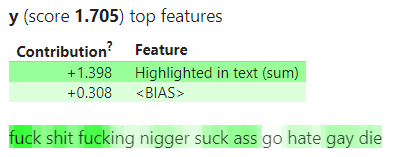
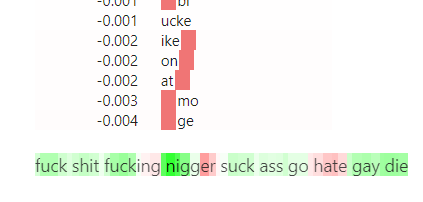

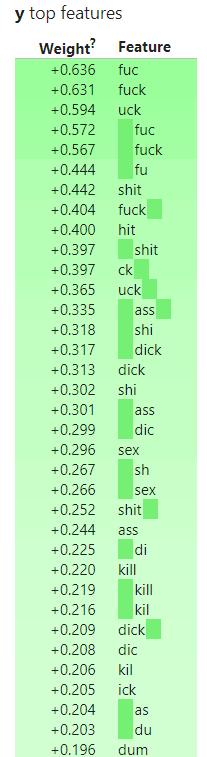

In addition, only a subset of the models were evaluated here for reasons of memory, file loading time, and clarity.

Print for each trained linear regression model the top 100 features sorted by their weights.

In [98]:
models_sequence = ["normal", "clean", "ruddit normal", "ruddit clean"]

for index, model_dict in enumerate(model_evaluation_list[:4]):
    rigde = model_dict["ridge"]
    lgbm = model_dict["lgbm"]
    tfvec = model_dict["tfvec"]

    print(f'Data: {models_sequence[index%len(models_sequence)]} \nRidge:')
    # remove <bias> rows
    display(eli5.show_weights(rigde, vec=tfvec, top=100, highlight_spaces=True, feature_filter=lambda feature: feature != '<BIAS>'))

    print(f'LGBM Model:')
    display(eli5.explain_weights_lightgbm(lgbm, vec=tfvec, top=100, feature_filter=lambda feature: feature != '<BIAS>'))

    print('------------------')

Data: normal 
Ridge:


LGBM Model:


Explanation(estimator="LGBMRegressor(n_estimators=1000, objective='regression', random_seed=42)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='uck', weight=0.2566389208887798, std=None, value=None), FeatureWeight(feature='fuc', weight=0.053761391984353986, std=None, value=None), FeatureWeight(feature='ion', weight=0.03304921590058068, std=None, value=None), FeatureWeight(feature=' nigg', weight=0.02643428507572845, std=None, value=None), FeatureWeight(feature=' gay', weight=0.02407217894307932, std=None, value=None), FeatureWeight(feature='kill ', weight=0.016096486786097885, std=None, value=None), FeatureWeight(feature='ed ', weight=0.013695938961162802, std=None, value=None), FeatureWeight(feature=' die', weight=0.01275267300198747, std=None, value=None), FeatureWeight(feature='tard', weight=0.011271930854591357, std=None, value=None), FeatureWeight(feature='fag', weight=0.010968506286130941, std=None, value=None), FeatureWeight(feature=' die ', weight=0.010576056264833888, std=None, value=None), FeatureWeight(feature=' nig', weight=0.01030169139176901, std=None, value=None), FeatureWeight(feature=' ass', weight=0.009898445304837553, std=None, value=None), FeatureWeight(feature='shit', weight=0.009076307889528928, std=None, value=None), FeatureWeight(feature='ggo', weight=0.008375374675385747, std=None, value=None), FeatureWeight(feature='igg', weight=0.008156676095183035, std=None, value=None), FeatureWeight(feature='ck ', weight=0.008123845537219275, std=None, value=None), FeatureWeight(feature='bitch', weight=0.007986390950090905, std=None, value=None), FeatureWeight(feature=' jew', weight=0.007943225505667026, std=None, value=None), FeatureWeight(feature=' gay ', weight=0.006406588454254407, std=None, value=None), FeatureWeight(feature=' fag', weight=0.005541096617476657, std=None, value=None), FeatureWeight(feature='nig', weight=0.005199920210194294, std=None, value=None), FeatureWeight(feature='stup', weight=0.005063058599822797, std=None, value=None), FeatureWeight(feature=' ck', weight=0.0050080116558220075, std=None, value=None), FeatureWeight(feature=' fa', weight=0.004659461236166737, std=None, value=None), FeatureWeight(feature=' homo', weight=0.004487898867420913, std=None, value=None), FeatureWeight(feature=' fat ', weight=0.004204270499507309, std=None, value=None), FeatureWeight(feature='tio', weight=0.004181272079778582, std=None, value=None), FeatureWeight(feature=' rape', weight=0.004109792374535847, std=None, value=None), FeatureWeight(feature=' je', weight=0.003878184976835743, std=None, value=None), FeatureWeight(feature=' ass ', weight=0.003809823422368845, std=None, value=None), FeatureWeight(feature='hit', weight=0.003748947078186635, std=None, value=None), FeatureWeight(feature='ass', weight=0.0037328292440242045, std=None, value=None), FeatureWeight(feature=' go', weight=0.0035551975033713532, std=None, value=None), FeatureWeight(feature='ing', weight=0.0032874188564914818, std=None, value=None), FeatureWeight(feature='ick', weight=0.003173182987067091, std=None, value=None), FeatureWeight(feature=' bi', weight=0.003142122446115535, std=None, value=None), FeatureWeight(feature=' ho', weight=0.0029516221962630966, std=None, value=None), FeatureWeight(feature=' rap', weight=0.002803837898128491, std=None, value=None), FeatureWeight(feature='fuck', weight=0.002762579262835934, std=None, value=None), FeatureWeight(feature=' hate', weight=0.00272260899952064, std=None, value=None), FeatureWeight(feature='ian', weight=0.0026538632369023643, std=None, value=None), FeatureWeight(feature=' go ', weight=0.002527768003791721, std=None, value=None), FeatureWeight(feature='diot', weight=0.002479673155211416, std=None, value=None), FeatureWeight(feature='upid ', weight=0.002464124722590434, std=None, value=

------------------
Data: clean 
Ridge:


LGBM Model:


Explanation(estimator="LGBMRegressor(n_estimators=1000, objective='regression', random_seed=42)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='uck', weight=0.2566389208887798, std=None, value=None), FeatureWeight(feature='fuc', weight=0.053761391984353986, std=None, value=None), FeatureWeight(feature='ion', weight=0.03304921590058068, std=None, value=None), FeatureWeight(feature=' nigg', weight=0.02643428507572845, std=None, value=None), FeatureWeight(feature=' gay', weight=0.02407217894307932, std=None, value=None), FeatureWeight(feature='kill ', weight=0.016096486786097885, std=None, value=None), FeatureWeight(feature='ed ', weight=0.013695938961162802, std=None, value=None), FeatureWeight(feature=' die', weight=0.01275267300198747, std=None, value=None), FeatureWeight(feature='tard', weight=0.011271930854591357, std=None, value=None), FeatureWeight(feature='fag', weight=0.010968506286130941, std=None, value=None), FeatureWeight(feature=' die ', weight=0.010576056264833888, std=None, value=None), FeatureWeight(feature=' nig', weight=0.01030169139176901, std=None, value=None), FeatureWeight(feature=' ass', weight=0.009898445304837553, std=None, value=None), FeatureWeight(feature='shit', weight=0.009076307889528928, std=None, value=None), FeatureWeight(feature='ggo', weight=0.008375374675385747, std=None, value=None), FeatureWeight(feature='igg', weight=0.008156676095183035, std=None, value=None), FeatureWeight(feature='ck ', weight=0.008123845537219275, std=None, value=None), FeatureWeight(feature='bitch', weight=0.007986390950090905, std=None, value=None), FeatureWeight(feature=' jew', weight=0.007943225505667026, std=None, value=None), FeatureWeight(feature=' gay ', weight=0.006406588454254407, std=None, value=None), FeatureWeight(feature=' fag', weight=0.005541096617476657, std=None, value=None), FeatureWeight(feature='nig', weight=0.005199920210194294, std=None, value=None), FeatureWeight(feature='stup', weight=0.005063058599822797, std=None, value=None), FeatureWeight(feature=' ck', weight=0.0050080116558220075, std=None, value=None), FeatureWeight(feature=' fa', weight=0.004659461236166737, std=None, value=None), FeatureWeight(feature=' homo', weight=0.004487898867420913, std=None, value=None), FeatureWeight(feature=' fat ', weight=0.004204270499507309, std=None, value=None), FeatureWeight(feature='tio', weight=0.004181272079778582, std=None, value=None), FeatureWeight(feature=' rape', weight=0.004109792374535847, std=None, value=None), FeatureWeight(feature=' je', weight=0.003878184976835743, std=None, value=None), FeatureWeight(feature=' ass ', weight=0.003809823422368845, std=None, value=None), FeatureWeight(feature='hit', weight=0.003748947078186635, std=None, value=None), FeatureWeight(feature='ass', weight=0.0037328292440242045, std=None, value=None), FeatureWeight(feature=' go', weight=0.0035551975033713532, std=None, value=None), FeatureWeight(feature='ing', weight=0.0032874188564914818, std=None, value=None), FeatureWeight(feature='ick', weight=0.003173182987067091, std=None, value=None), FeatureWeight(feature=' bi', weight=0.003142122446115535, std=None, value=None), FeatureWeight(feature=' ho', weight=0.0029516221962630966, std=None, value=None), FeatureWeight(feature=' rap', weight=0.002803837898128491, std=None, value=None), FeatureWeight(feature='fuck', weight=0.002762579262835934, std=None, value=None), FeatureWeight(feature=' hate', weight=0.00272260899952064, std=None, value=None), FeatureWeight(feature='ian', weight=0.0026538632369023643, std=None, value=None), FeatureWeight(feature=' go ', weight=0.002527768003791721, std=None, value=None), FeatureWeight(feature='diot', weight=0.002479673155211416, std=None, value=None), FeatureWeight(feature='upid ', weight=0.002464124722590434, std=None, value=

------------------
Data: ruddit normal 
Ridge:


LGBM Model:


Explanation(estimator="LGBMRegressor(n_estimators=1000, objective='regression', random_seed=42)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='fuc', weight=0.2354761714953603, std=None, value=None), FeatureWeight(feature='fuck', weight=0.08157689227464264, std=None, value=None), FeatureWeight(feature='shit', weight=0.034074517316581295, std=None, value=None), FeatureWeight(feature='sex', weight=0.022058341285398787, std=None, value=None), FeatureWeight(feature=' dick', weight=0.021530179803068112, std=None, value=None), FeatureWeight(feature='hit', weight=0.013031597448973477, std=None, value=None), FeatureWeight(feature=' kill', weight=0.010034580993744945, std=None, value=None), FeatureWeight(feature=' ass ', weight=0.00987814045918518, std=None, value=None), FeatureWeight(feature='d] ', weight=0.009385054004740684, std=None, value=None), FeatureWeight(feature=' an', weight=0.008632911795424497, std=None, value=None), FeatureWeight(feature=' stup', weight=0.00807859041308887, std=None, value=None), FeatureWeight(feature=' gay', weight=0.006899724838662615, std=None, value=None), FeatureWeight(feature=' i ', weight=0.006694301438972262, std=None, value=None), FeatureWeight(feature=' sh', weight=0.0066226704994868215, std=None, value=None), FeatureWeight(feature=' ass', weight=0.006392119852628535, std=None, value=None), FeatureWeight(feature='ing ', weight=0.005345797492007651, std=None, value=None), FeatureWeight(feature='uck', weight=0.005246978660255243, std=None, value=None), FeatureWeight(feature='ist', weight=0.004995568654746153, std=None, value=None), FeatureWeight(feature='ism', weight=0.004809859110874169, std=None, value=None), FeatureWeight(feature=' rap', weight=0.004495978513530924, std=None, value=None), FeatureWeight(feature='dum', weight=0.004468044574296199, std=None, value=None), FeatureWeight(feature='hell', weight=0.004424618000100972, std=None, value=None), FeatureWeight(feature=' kil', weight=0.004250064538227966, std=None, value=None), FeatureWeight(feature='to ', weight=0.003831520264419522, std=None, value=None), FeatureWeight(feature='peo', weight=0.003795870982193991, std=None, value=None), FeatureWeight(feature=' ki', weight=0.003677059972435734, std=None, value=None), FeatureWeight(feature=' wa', weight=0.003628082402597584, std=None, value=None), FeatureWeight(feature='ing', weight=0.0035655110494537895, std=None, value=None), FeatureWeight(feature=' th', weight=0.0033881453454079865, std=None, value=None), FeatureWeight(feature=' this', weight=0.003080747435063312, std=None, value=None), FeatureWeight(feature='ck ', weight=0.0029382476196600396, std=None, value=None), FeatureWeight(feature='se ', weight=0.002701750636116931, std=None, value=None), FeatureWeight(feature='the', weight=0.0026367129308708655, std=None, value=None), FeatureWeight(feature='porn', weight=0.002623018029895095, std=None, value=None), FeatureWeight(feature=' as', weight=0.00258258716844191, std=None, value=None), FeatureWeight(feature=' die', weight=0.0025543716979433404, std=None, value=None), FeatureWeight(feature=' du', weight=0.002507867889074742, std=None, value=None), FeatureWeight(feature=' yo', weight=0.0024887949810730625, std=None, value=None), FeatureWeight(feature=' gu', weight=0.0024859396625074403, std=None, value=None), FeatureWeight(feature='wom', weight=0.0023866149177631346, std=None, value=None), FeatureWeight(feature='rap', weight=0.002374625951541835, std=None, value=None), FeatureWeight(feature=' a ', weight=0.0023063199410529854, std=None, value=None), FeatureWeight(feature='re ', weight=0.0022744599661436242, std=None, value=None), FeatureWeight(feature='ole', weight=0.0021533842492219733, std=None, value=None), FeatureWeight(feature=' di', weight=0.0021324498526837554, std=None, value=None),

------------------
Data: ruddit clean 
Ridge:


LGBM Model:


Explanation(estimator="LGBMRegressor(n_estimators=1000, objective='regression', random_seed=42)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='fuc', weight=0.2832771224447586, std=None, value=None), FeatureWeight(feature='shit', weight=0.030111550203158765, std=None, value=None), FeatureWeight(feature='sex', weight=0.020625644263623174, std=None, value=None), FeatureWeight(feature=' dick', weight=0.018663954414645304, std=None, value=None), FeatureWeight(feature=' ass ', weight=0.016971686787552672, std=None, value=None), FeatureWeight(feature=' fuc', weight=0.015027243703102685, std=None, value=None), FeatureWeight(feature='ed ', weight=0.01292492865433921, std=None, value=None), FeatureWeight(feature='hit', weight=0.012886116281664283, std=None, value=None), FeatureWeight(feature=' kill', weight=0.010267753149975476, std=None, value=None), FeatureWeight(feature=' fuck', weight=0.00946494025170062, std=None, value=None), FeatureWeight(feature='fuck', weight=0.008709931078052017, std=None, value=None), FeatureWeight(feature='ing ', weight=0.007862846338934328, std=None, value=None), FeatureWeight(feature=' stup', weight=0.007777021031325312, std=None, value=None), FeatureWeight(feature=' gay', weight=0.007075140500678483, std=None, value=None), FeatureWeight(feature=' kil', weight=0.005857986328199911, std=None, value=None), FeatureWeight(feature='hell ', weight=0.005576877405124376, std=None, value=None), FeatureWeight(feature='dum', weight=0.00522637446726625, std=None, value=None), FeatureWeight(feature='ist', weight=0.00500635990451182, std=None, value=None), FeatureWeight(feature='uck', weight=0.004812572678310767, std=None, value=None), FeatureWeight(feature=' peo', weight=0.004731151081659109, std=None, value=None), FeatureWeight(feature='ck ', weight=0.004724705972059835, std=None, value=None), FeatureWeight(feature=' rap', weight=0.004456127025982216, std=None, value=None), FeatureWeight(feature='shit ', weight=0.004389639715071781, std=None, value=None), FeatureWeight(feature=' an', weight=0.004187627689530922, std=None, value=None), FeatureWeight(feature=' wo', weight=0.004016857451056986, std=None, value=None), FeatureWeight(feature='dick ', weight=0.0038811197866376965, std=None, value=None), FeatureWeight(feature=' de', weight=0.003841836209690955, std=None, value=None), FeatureWeight(feature='ing', weight=0.003749271619771909, std=None, value=None), FeatureWeight(feature=' ki', weight=0.0034482254196561784, std=None, value=None), FeatureWeight(feature='sex ', weight=0.003262745443516945, std=None, value=None), FeatureWeight(feature='uck ', weight=0.0031930283712722353, std=None, value=None), FeatureWeight(feature='ons', weight=0.0029209923920358863, std=None, value=None), FeatureWeight(feature=' du', weight=0.0029207693802901324, std=None, value=None), FeatureWeight(feature='ism', weight=0.002906475158467728, std=None, value=None), FeatureWeight(feature='an ', weight=0.0025929931221564686, std=None, value=None), FeatureWeight(feature='ts ', weight=0.002578211384108081, std=None, value=None), FeatureWeight(feature='let', weight=0.0024901357082396723, std=None, value=None), FeatureWeight(feature='hank', weight=0.0024863622798808006, std=None, value=None), FeatureWeight(feature='ole', weight=0.0023648062030005006, std=None, value=None), FeatureWeight(feature=' ass', weight=0.0023543635353992986, std=None, value=None), FeatureWeight(feature='hil', weight=0.002237858559601432, std=None, value=None), FeatureWeight(feature=' shit', weight=0.00221588962905103, std=None, value=None), FeatureWeight(feature='rap', weight=0.0021840228525872667, std=None, value=None), FeatureWeight(feature=' awe', weight=0.0021551504120718525, std=None, value=None), FeatureWeight(feature='sho', weight=0.0020925450946952012, std=None, va

------------------


It shows some interesting differences between the each model. Model trained with not cleaned data have some special characters in their top 100 toxic features. Moreover comments annotated with "/s" seem to be toxic in this models. "/s" stands for sarcastic comments. So the models seem to classify sarcastic comments as toxic. In the exploration carried out at the beginning, most of the words from the texts marked as toxic were summarized. In the top features of all models, clear word parts of these words can be recognized. It can be concluded that the models can clearly identify and assign insults. Further, it can be said that the majority of comments that identify the models as toxic include insults.
With this knowledge, a few test sentences are to be evaluated by the models.

In [99]:
example_sentences = [
    # non toxic sentence
    "i love data mining",

    # sarcastic sentence marked with /s
    "I am busy right now, can I ignore you some other time? /s",

    # let's rate a quote: “Complications arose, ensued, were overcome” ~ Captain Jack Sparrow
    "Complications arose, ensued, were overcome.",

    # random sentence from dataset
    train["comment_text"].values[random.randint(0, len(train["comment_text"].values) - 1)],

    # most words used in as toxic marked texts (see data exploration)
    "fuck shit fucking nigger suck ass go hate gay die"
]

# lgbm didn't work well with explain predictions. So it got just printed once
for sentence in example_sentences:
    for index, model_dict in enumerate(model_evaluation_list[:4]):
        rigde = model_dict["ridge"]
        tfvec = model_dict["tfvec"]

        print(f'Data: {models_sequence[index%len(models_sequence)]} \nRidge:')
        display(eli5.explain_prediction(rigde, sentence, vec=tfvec))
        print('------------------')


Data: normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='ta ', weight=0.006526479613341773, std=None, value=0.18606113738261476), FeatureWeight(feature='ini', weight=0.0019185841596959035, std=None, value=0.13670142019238124), FeatureWeight(feature=' da', weight=0.00010377426166088216, std=None, value=0.1270368510851203), FeatureWeight(feature='ng ', weight=1.3115538715146672e-05, std=None, value=0.060964442571901756)], neg=[FeatureWeight(feature=' mi', weight=-0.008975195607417432, std=None, value=0.1199069689018655), FeatureWeight(feature=' min', weight=-0.008189555374019239, std=None, value=0.16156816964564055), FeatureWeight(feature=' lo', weight=-0.008057898681146433, std=None, value=0.10527650112948175), FeatureWeight(feature='dat', weight=-0.006301182537319254, std=None, value=0.1690914452031906), FeatureWeight(feature='ove', weight=-0.005556572293447609, std=None, value=0.11501467042258541), FeatureWeight(feature='min', weight=-0.00462376028592846, std=None, value=0.11817181359104358), FeatureWeight(feature=' dat', weight=-0.0046215256525710575, std=None, value=0.19404613451952438), FeatureWeight(feature='love', weight=-0.00442902575482842, std=None, value=0.18372975175086106), FeatureWeight(feature='data ', weight=-0.004264732062960033, std=None, value=0.23592645884969168), FeatureWeight(feature=' love', weight=-0.0036823440202855824, std=None, value=0.1898467572259931), FeatureWeight(feature='ata', weight=-0.0036298535709126194, std=None, value=0.19085439789552594), FeatureWeight(feature='ove ', weight=-0.003565676113466864, std=None, value=0.14804301324379654), FeatureWeight(feature='lov', weight=-0.002943846280673273, std=None, value=0.17796364064709985), FeatureWeight(feature=' mini', weight=-0.002796397477170254, std=None, value=0.2555708126435291), FeatureWeight(feature='minin', weight=-0.0020183435205570156, std=None, value=0.2841028185074342), FeatureWeight(feature='ata ', weight=-0.0017997745124842804, std=None, value=0.22541666702943866), FeatureWeight(feature=' lov', weight=-0.0016189379100252847, std=None, value=0.1845875438659472), FeatureWeight(feature='mini', weight=-0.0015337590512806564, std=None, value=0.18517022297324331), FeatureWeight(feature='ning ', weight=-0.0011772026682333964, std=None, value=0.14045834788687628), FeatureWeight(feature='ing', weight=-0.0011751515257492145, std=None, value=0.06115072733393706), FeatureWeight(feature='data', weight=-0.0011440630808021845, std=None, value=0.2289150854978639), FeatureWeight(feature='love ', weight=-0.0010525107678749388, std=None, value=0.20090988356198916), FeatureWeight(feature='ning', weight=-0.0009128502699364158, std=None, value=0.13720412127702497), FeatureWeight(feature='ing ', weight=-0.0007092390705639209, std=None, value=0.06216776795642473), FeatureWeight(feature='ining', weight=-0.0006085813907256976, std=None, value=0.20090988356198916), FeatureWeight(feature='inin', weight=-0.0004911263206308891, std=None, value=0.19834519437120302), FeatureWeight(feature=' data', weight=-0.00046061412811684263, std=None, value=0.23378945990999858), FeatureWeight(feature='nin', weight=-6.35837538919017e-05, std=None, value=0.13475386047993435), FeatureWeight(feature='ve ', weight=-5.855514558370847e-05, std=None, value=0.09854803004929562)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.011114055825796151, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='i love data mining', spans=[(' lo', [(1, 4)], -0.008057898681146433), ('lov', [(2, 5)], -0.002943846280673273), ('ove', [(3, 6)], -0.005556572293447609), ('ve ', [(4, 7)], -5.855514558370847e-05), (' lov', [(1, 5)], -0.0016189379100252847), ('love', [(2, 6)], -0.00442902575482842), ('ove ', [(3, 7)], -0.003565676113466864), (' love', [(1

------------------
Data: clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='ta ', weight=0.006526479613341773, std=None, value=0.18606113738261476), FeatureWeight(feature='ini', weight=0.0019185841596959035, std=None, value=0.13670142019238124), FeatureWeight(feature=' da', weight=0.00010377426166088216, std=None, value=0.1270368510851203), FeatureWeight(feature='ng ', weight=1.3115538715146672e-05, std=None, value=0.060964442571901756)], neg=[FeatureWeight(feature=' mi', weight=-0.008975195607417432, std=None, value=0.1199069689018655), FeatureWeight(feature=' min', weight=-0.008189555374019239, std=None, value=0.16156816964564055), FeatureWeight(feature=' lo', weight=-0.008057898681146433, std=None, value=0.10527650112948175), FeatureWeight(feature='dat', weight=-0.006301182537319254, std=None, value=0.1690914452031906), FeatureWeight(feature='ove', weight=-0.005556572293447609, std=None, value=0.11501467042258541), FeatureWeight(feature='min', weight=-0.00462376028592846, std=None, value=0.11817181359104358), FeatureWeight(feature=' dat', weight=-0.0046215256525710575, std=None, value=0.19404613451952438), FeatureWeight(feature='love', weight=-0.00442902575482842, std=None, value=0.18372975175086106), FeatureWeight(feature='data ', weight=-0.004264732062960033, std=None, value=0.23592645884969168), FeatureWeight(feature=' love', weight=-0.0036823440202855824, std=None, value=0.1898467572259931), FeatureWeight(feature='ata', weight=-0.0036298535709126194, std=None, value=0.19085439789552594), FeatureWeight(feature='ove ', weight=-0.003565676113466864, std=None, value=0.14804301324379654), FeatureWeight(feature='lov', weight=-0.002943846280673273, std=None, value=0.17796364064709985), FeatureWeight(feature=' mini', weight=-0.002796397477170254, std=None, value=0.2555708126435291), FeatureWeight(feature='minin', weight=-0.0020183435205570156, std=None, value=0.2841028185074342), FeatureWeight(feature='ata ', weight=-0.0017997745124842804, std=None, value=0.22541666702943866), FeatureWeight(feature=' lov', weight=-0.0016189379100252847, std=None, value=0.1845875438659472), FeatureWeight(feature='mini', weight=-0.0015337590512806564, std=None, value=0.18517022297324331), FeatureWeight(feature='ning ', weight=-0.0011772026682333964, std=None, value=0.14045834788687628), FeatureWeight(feature='ing', weight=-0.0011751515257492145, std=None, value=0.06115072733393706), FeatureWeight(feature='data', weight=-0.0011440630808021845, std=None, value=0.2289150854978639), FeatureWeight(feature='love ', weight=-0.0010525107678749388, std=None, value=0.20090988356198916), FeatureWeight(feature='ning', weight=-0.0009128502699364158, std=None, value=0.13720412127702497), FeatureWeight(feature='ing ', weight=-0.0007092390705639209, std=None, value=0.06216776795642473), FeatureWeight(feature='ining', weight=-0.0006085813907256976, std=None, value=0.20090988356198916), FeatureWeight(feature='inin', weight=-0.0004911263206308891, std=None, value=0.19834519437120302), FeatureWeight(feature=' data', weight=-0.00046061412811684263, std=None, value=0.23378945990999858), FeatureWeight(feature='nin', weight=-6.35837538919017e-05, std=None, value=0.13475386047993435), FeatureWeight(feature='ve ', weight=-5.855514558370847e-05, std=None, value=0.09854803004929562)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.011114055825796151, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='i love data mining', spans=[(' lo', [(1, 4)], -0.008057898681146433), ('lov', [(2, 5)], -0.002943846280673273), ('ove', [(3, 6)], -0.005556572293447609), ('ve ', [(4, 7)], -5.855514558370847e-05), (' lov', [(1, 5)], -0.0016189379100252847), ('love', [(2, 6)], -0.00442902575482842), ('ove ', [(3, 7)], -0.003565676113466864), (' love', [(1

------------------
Data: ruddit normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.3171578318038884, std=None, value=1.0), FeatureWeight(feature='ta ', weight=0.010050996849180071, std=None, value=0.20174412895552868), FeatureWeight(feature='ing', weight=0.008417008190406843, std=None, value=0.055591530541245694), FeatureWeight(feature=' dat', weight=0.007347947964345152, std=None, value=0.19609834779204585), FeatureWeight(feature='ing ', weight=0.006117684736474575, std=None, value=0.05898379953572363), FeatureWeight(feature='ng ', weight=0.005640238325460738, std=None, value=0.05796052550654308), FeatureWeight(feature='mini', weight=0.0037853293596494565, std=None, value=0.1940662965918785), FeatureWeight(feature='minin', weight=0.003564471441893246, std=None, value=0.2695470200033774), FeatureWeight(feature='ning', weight=0.002476116528273727, std=None, value=0.13723642409226108), FeatureWeight(feature='inin', weight=0.002414231921136609, std=None, value=0.19506801007903085), FeatureWeight(feature='ining', weight=0.002297991747615662, std=None, value=0.19662477125283284), FeatureWeight(feature='ning ', weight=0.0020132878197227488, std=None, value=0.14610945115765445), FeatureWeight(feature='dat', weight=0.0014825085179314035, std=None, value=0.1651001405732641), FeatureWeight(feature=' da', weight=0.001424775747764503, std=None, value=0.13045829845286694), FeatureWeight(feature='nin', weight=0.0012195102239909586, std=None, value=0.13583393861831722), FeatureWeight(feature='min', weight=0.0005911982287841341, std=None, value=0.12326844061984403), FeatureWeight(feature='ini', weight=2.8349382976929916e-05, std=None, value=0.139016202536169)], neg=[FeatureWeight(feature='love ', weight=-0.019310119773310187, std=None, value=0.18815660433729584), FeatureWeight(feature=' i ', weight=-0.01746153116901845, std=None, value=0.07227094415883946), FeatureWeight(feature='ove ', weight=-0.01582617230405601, std=None, value=0.1547818554807136), FeatureWeight(feature='love', weight=-0.010318118632387423, std=None, value=0.1773660950782873), FeatureWeight(feature='lov', weight=-0.009240876840351842, std=None, value=0.17438428417878793), FeatureWeight(feature=' love', weight=-0.008601074760215209, std=None, value=0.17831093603120193), FeatureWeight(feature=' lov', weight=-0.007852186822326366, std=None, value=0.17554759043753965), FeatureWeight(feature=' lo', weight=-0.007287029390640488, std=None, value=0.09886829488023656), FeatureWeight(feature='ata ', weight=-0.00475347387663392, std=None, value=0.24455257168618166), FeatureWeight(feature=' min', weight=-0.00416246070608547, std=None, value=0.1547818554807136), FeatureWeight(feature=' mi', weight=-0.004116838789425179, std=None, value=0.11500080168825888), FeatureWeight(feature='ata', weight=-0.003751067254866318, std=None, value=0.21071916278381836), FeatureWeight(feature='data ', weight=-0.003619236457143633, std=None, value=0.24879975335253093), FeatureWeight(feature=' mini', weight=-0.003611461249318764, std=None, value=0.23270692309350005), FeatureWeight(feature='ve ', weight=-0.0025813331985959365, std=None, value=0.0762786952876122), FeatureWeight(feature='ove', weight=-0.0009409736923175213, std=None, value=0.108233938108356), FeatureWeight(feature=' data', weight=-0.000289252629290637, std=None, value=0.23731651350521546), FeatureWeight(feature='data', weight=-0.000289252629290637, std=None, value=0.23731651350521546)], pos_remaining=0, neg_remaining=0), proba=None, score=0.25201701861422116, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='i love data mining', spans=[(' i ', [(-1, 2)], -0.01746153116901845), (' lo', [(1, 4)], -0.007287029390640488), ('lov', [(2, 5)], -0.009240876840351842), ('ove', [(3, 6)], -0.0009409736923175213), ('ve ', [(4, 7)], -0.0025813331985959365), (' lov', [(1, 5)], -0.00785218682232

------------------
Data: ruddit clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.30772333387096384, std=None, value=1.0), FeatureWeight(feature='ta ', weight=0.02305150302109116, std=None, value=0.19243223804278956), FeatureWeight(feature='ing', weight=0.007862377666481776, std=None, value=0.05756377382945615), FeatureWeight(feature='ing ', weight=0.007795733641201751, std=None, value=0.058985504858320444), FeatureWeight(feature=' dat', weight=0.007058390507388271, std=None, value=0.1972893920940086), FeatureWeight(feature='ng ', weight=0.006782029043045316, std=None, value=0.05776510989455567), FeatureWeight(feature='ining', weight=0.004955886537884416, std=None, value=0.19834380281639719), FeatureWeight(feature='inin', weight=0.004815393792819049, std=None, value=0.19677343134528807), FeatureWeight(feature=' da', weight=0.004619808202720492, std=None, value=0.13075485970416026), FeatureWeight(feature='minin', weight=0.0038130092428532787, std=None, value=0.2719035889763411), FeatureWeight(feature='ning', weight=0.003412874693009655, std=None, value=0.13843624109996633), FeatureWeight(feature='ning ', weight=0.0033524399491245173, std=None, value=0.14077693649991915), FeatureWeight(feature='ove', weight=0.0031401021200746517, std=None, value=0.11889920776701925), FeatureWeight(feature='mini', weight=0.0020629164099124084, std=None, value=0.19576296017673528), FeatureWeight(feature='nin', weight=0.002028497277579331, std=None, value=0.13702149411501452), FeatureWeight(feature='dat', weight=0.001794461184451254, std=None, value=0.16654356171997917), FeatureWeight(feature='min', weight=0.0007021088287500299, std=None, value=0.12434613972594695)], neg=[FeatureWeight(feature='love ', weight=-0.018574578480838627, std=None, value=0.18542341769842605), FeatureWeight(feature='ove ', weight=-0.01259839964995583, std=None, value=0.15630307936080784), FeatureWeight(feature='love', weight=-0.008269449477469952, std=None, value=0.17891675379642852), FeatureWeight(feature=' love', weight=-0.0075265388711380195, std=None, value=0.17923168756370136), FeatureWeight(feature='lov', weight=-0.007326521974997677, std=None, value=0.1759088738161101), FeatureWeight(feature=' lov', weight=-0.006766910517226916, std=None, value=0.17649088019876108), FeatureWeight(feature='ata', weight=-0.0047371792600763565, std=None, value=0.21256141739683176), FeatureWeight(feature=' mini', weight=-0.00402573913110453, std=None, value=0.2347414101182467), FeatureWeight(feature=' lo', weight=-0.003632063405527886, std=None, value=0.09913317242308445), FeatureWeight(feature='ata ', weight=-0.003293440308327507, std=None, value=0.23777438469969428), FeatureWeight(feature=' mi', weight=-0.0028363077311083446, std=None, value=0.11556396919705665), FeatureWeight(feature='data ', weight=-0.0022418630201000954, std=None, value=0.24108344882591828), FeatureWeight(feature=' data', weight=-0.0019768761355362665, std=None, value=0.2393913008001791), FeatureWeight(feature='data', weight=-0.0019768761355362665, std=None, value=0.2393913008001791), FeatureWeight(feature='ini', weight=-0.001680280950881381, std=None, value=0.14023157961446828), FeatureWeight(feature=' min', weight=-0.0011329868237200083, std=None, value=0.15547067180241708), FeatureWeight(feature='ve ', weight=-0.00022358455169829434, std=None, value=0.09895871346566552)], pos_remaining=0, neg_remaining=0), proba=None, score=0.30615126956410726, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='i love data mining', spans=[(' lo', [(1, 4)], -0.003632063405527886), ('lov', [(2, 5)], -0.007326521974997677), ('ove', [(3, 6)], 0.0031401021200746517), ('ve ', [(4, 7)], -0.00022358455169829434), (' lov', [(1, 5)], -0.006766910517226916), ('love', [(2, 6)], -0.008269449477469952), ('ove ', [(3, 7)], -0.01259839964995583), (' love', [(1, 6)], -0.007526538871

------------------
Data: normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature=' bu', weight=0.01132852104108142, std=None, value=0.09298863992177646), FeatureWeight(feature='can', weight=0.009786004000673497, std=None, value=0.10190717655879493), FeatureWeight(feature='ou ', weight=0.008253313701999556, std=None, value=0.16157055921683222), FeatureWeight(feature='am ', weight=0.005740448736636079, std=None, value=0.11361504546613187), FeatureWeight(feature='an ', weight=0.004756435097246826, std=None, value=0.06864264308010318), FeatureWeight(feature=' yo', weight=0.004067499071551276, std=None, value=0.12091761949206878), FeatureWeight(feature='you ', weight=0.003684384536917918, std=None, value=0.17616237292789733), FeatureWeight(feature='you', weight=0.003583657474850396, std=None, value=0.13089805243506306), FeatureWeight(feature='can ', weight=0.0035296100865359207, std=None, value=0.12842590282321023), FeatureWeight(feature='re ', weight=0.0030365670185725467, std=None, value=0.07182137816279455), FeatureWeight(feature=' am', weight=0.0030008605794058607, std=None, value=0.10483880844289212), FeatureWeight(feature='gno', weight=0.0027607015486517876, std=None, value=0.1293864085187665), FeatureWeight(feature='ore ', weight=0.001718059983909815, std=None, value=0.11322080957364686), FeatureWeight(feature=' can', weight=0.0015598894177845598, std=None, value=0.12490717675050526), FeatureWeight(feature='ome ', weight=0.001387229864768092, std=None, value=0.10012352109488444), FeatureWeight(feature=' so', weight=0.0012454582768099479, std=None, value=0.06612516732544733), FeatureWeight(feature=' you', weight=0.0009994828629899862, std=None, value=0.1380305602389747), FeatureWeight(feature='ore', weight=0.0009745366671316146, std=None, value=0.09758964814011548), FeatureWeight(feature='ht ', weight=0.0009703927620850247, std=None, value=0.08021170460872268), FeatureWeight(feature=' igno', weight=0.0008948534781066592, std=None, value=0.13222946614702377), FeatureWeight(feature='igno', weight=0.0008559822644010999, std=None, value=0.1319576060985052), FeatureWeight(feature='ignor', weight=0.0008099283462604346, std=None, value=0.13222946614702377), FeatureWeight(feature='gnor', weight=0.0008099283462604346, std=None, value=0.13222946614702377), FeatureWeight(feature='ght ', weight=0.000569044817936893, std=None, value=0.08050199622673761), FeatureWeight(feature='other', weight=0.000549356901397098, std=None, value=0.08760241091611), FeatureWeight(feature=' ign', weight=0.0005078248298995062, std=None, value=0.1319576060985052), FeatureWeight(feature='ight ', weight=0.0004388351446253099, std=None, value=0.08508395892968162), FeatureWeight(feature='bus', weight=0.0003977273639335974, std=None, value=0.12005253658593815), FeatureWeight(feature='the', weight=0.0003650772519841528, std=None, value=0.06967509574449873), FeatureWeight(feature='ght', weight=0.00027678677350873244, std=None, value=0.07639622698723707), FeatureWeight(feature='er ', weight=0.0001673566054364345, std=None, value=0.047852892533072004), FeatureWeight(feature='othe', weight=0.0001242951532142829, std=None, value=0.08707858204857731)], neg=[FeatureWeight(feature=' ot', weight=-0.006549684371181309, std=None, value=0.11525542393228022), FeatureWeight(feature=' oth', weight=-0.006208940302156778, std=None, value=0.11655832178548686), FeatureWeight(feature=' othe', weight=-0.006207653296814947, std=None, value=0.1167072528393724), FeatureWeight(feature=' busy', weight=-0.006129200463569805, std=None, value=0.17771985188730244), FeatureWeight(feature='busy', weight=-0.006129200463569805, std=None, value=0.17771985188730244), FeatureWeight(feature='busy ', weight=-0.005861045937539485, std=None, value=0.17937788101360763), FeatureWeight(feature=' ri', weight=-

------------------
Data: clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature=' bu', weight=0.01132852104108142, std=None, value=0.09298863992177646), FeatureWeight(feature='can', weight=0.009786004000673497, std=None, value=0.10190717655879493), FeatureWeight(feature='ou ', weight=0.008253313701999556, std=None, value=0.16157055921683222), FeatureWeight(feature='am ', weight=0.005740448736636079, std=None, value=0.11361504546613187), FeatureWeight(feature='an ', weight=0.004756435097246826, std=None, value=0.06864264308010318), FeatureWeight(feature=' yo', weight=0.004067499071551276, std=None, value=0.12091761949206878), FeatureWeight(feature='you ', weight=0.003684384536917918, std=None, value=0.17616237292789733), FeatureWeight(feature='you', weight=0.003583657474850396, std=None, value=0.13089805243506306), FeatureWeight(feature='can ', weight=0.0035296100865359207, std=None, value=0.12842590282321023), FeatureWeight(feature='re ', weight=0.0030365670185725467, std=None, value=0.07182137816279455), FeatureWeight(feature=' am', weight=0.0030008605794058607, std=None, value=0.10483880844289212), FeatureWeight(feature='gno', weight=0.0027607015486517876, std=None, value=0.1293864085187665), FeatureWeight(feature='ore ', weight=0.001718059983909815, std=None, value=0.11322080957364686), FeatureWeight(feature=' can', weight=0.0015598894177845598, std=None, value=0.12490717675050526), FeatureWeight(feature='ome ', weight=0.001387229864768092, std=None, value=0.10012352109488444), FeatureWeight(feature=' so', weight=0.0012454582768099479, std=None, value=0.06612516732544733), FeatureWeight(feature=' you', weight=0.0009994828629899862, std=None, value=0.1380305602389747), FeatureWeight(feature='ore', weight=0.0009745366671316146, std=None, value=0.09758964814011548), FeatureWeight(feature='ht ', weight=0.0009703927620850247, std=None, value=0.08021170460872268), FeatureWeight(feature=' igno', weight=0.0008948534781066592, std=None, value=0.13222946614702377), FeatureWeight(feature='igno', weight=0.0008559822644010999, std=None, value=0.1319576060985052), FeatureWeight(feature='ignor', weight=0.0008099283462604346, std=None, value=0.13222946614702377), FeatureWeight(feature='gnor', weight=0.0008099283462604346, std=None, value=0.13222946614702377), FeatureWeight(feature='ght ', weight=0.000569044817936893, std=None, value=0.08050199622673761), FeatureWeight(feature='other', weight=0.000549356901397098, std=None, value=0.08760241091611), FeatureWeight(feature=' ign', weight=0.0005078248298995062, std=None, value=0.1319576060985052), FeatureWeight(feature='ight ', weight=0.0004388351446253099, std=None, value=0.08508395892968162), FeatureWeight(feature='bus', weight=0.0003977273639335974, std=None, value=0.12005253658593815), FeatureWeight(feature='the', weight=0.0003650772519841528, std=None, value=0.06967509574449873), FeatureWeight(feature='ght', weight=0.00027678677350873244, std=None, value=0.07639622698723707), FeatureWeight(feature='er ', weight=0.0001673566054364345, std=None, value=0.047852892533072004), FeatureWeight(feature='othe', weight=0.0001242951532142829, std=None, value=0.08707858204857731)], neg=[FeatureWeight(feature=' ot', weight=-0.006549684371181309, std=None, value=0.11525542393228022), FeatureWeight(feature=' oth', weight=-0.006208940302156778, std=None, value=0.11655832178548686), FeatureWeight(feature=' othe', weight=-0.006207653296814947, std=None, value=0.1167072528393724), FeatureWeight(feature=' busy', weight=-0.006129200463569805, std=None, value=0.17771985188730244), FeatureWeight(feature='busy', weight=-0.006129200463569805, std=None, value=0.17771985188730244), FeatureWeight(feature='busy ', weight=-0.005861045937539485, std=None, value=0.17937788101360763), FeatureWeight(feature=' ri', weight=-

------------------
Data: ruddit normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.3171578318038884, std=None, value=1.0), FeatureWeight(feature=' /s', weight=0.018144200285771166, std=None, value=0.14571468166860027), FeatureWeight(feature='/s ', weight=0.016935367931929624, std=None, value=0.14378817956121187), FeatureWeight(feature=' /s ', weight=0.016389279019021454, std=None, value=0.14674467235782981), FeatureWeight(feature='me?', weight=0.005907092759884184, std=None, value=0.15015769281351068), FeatureWeight(feature='ow,', weight=0.004937851432639303, std=None, value=0.12008774282723901), FeatureWeight(feature='ow, ', weight=0.004937851432639303, std=None, value=0.12008774282723901), FeatureWeight(feature='igno', weight=0.0046222339257924105, std=None, value=0.13361376293215227), FeatureWeight(feature=' igno', weight=0.0046222339257924105, std=None, value=0.13361376293215227), FeatureWeight(feature=' ign', weight=0.0046222339257924105, std=None, value=0.13361376293215227), FeatureWeight(feature='ignor', weight=0.0046222339257924105, std=None, value=0.13361376293215227), FeatureWeight(feature='gnor', weight=0.0046222339257924105, std=None, value=0.13361376293215227), FeatureWeight(feature='sy ', weight=0.004595287701440459, std=None, value=0.11826692496361615), FeatureWeight(feature='an ', weight=0.004418340604275629, std=None, value=0.048023968344613616), FeatureWeight(feature='you', weight=0.00406430919342881, std=None, value=0.045818504145564126), FeatureWeight(feature=' ig', weight=0.003933491855130595, std=None, value=0.13087685018680215), FeatureWeight(feature=' yo', weight=0.0036482858390780573, std=None, value=0.04591816286009652), FeatureWeight(feature=' you', weight=0.0036177211290043163, std=None, value=0.04597372325821244), FeatureWeight(feature='me? ', weight=0.003497112939926484, std=None, value=0.15276550427744914), FeatureWeight(feature='bus', weight=0.003299581963095307, std=None, value=0.10604368101529078), FeatureWeight(feature=' no', weight=0.0029584212807572774, std=None, value=0.04610763983802478), FeatureWeight(feature='e? ', weight=0.002913603280760526, std=None, value=0.09299236714698592), FeatureWeight(feature='ign', weight=0.0028933867519617723, std=None, value=0.09786328370961447), FeatureWeight(feature='gno', weight=0.0028891876477512876, std=None, value=0.12753750968940128), FeatureWeight(feature='busy ', weight=0.0026538945291180558, std=None, value=0.1710688350426032), FeatureWeight(feature='usy ', weight=0.0026538945291180558, std=None, value=0.1710688350426032), FeatureWeight(feature='you ', weight=0.002615916352117388, std=None, value=0.05177934225095835), FeatureWeight(feature='w, ', weight=0.0025768738330753634, std=None, value=0.11241319426758961), FeatureWeight(feature='ime', weight=0.002472814650342462, std=None, value=0.07204507665348742), FeatureWeight(feature='ou ', weight=0.002344981606039715, std=None, value=0.05175043779903269), FeatureWeight(feature='nor', weight=0.002343292525854532, std=None, value=0.09845060745845728), FeatureWeight(feature='ght', weight=0.002135073843949902, std=None, value=0.06424211407244777), FeatureWeight(feature='er ', weight=0.002123257185118848, std=None, value=0.042586148352846166), FeatureWeight(feature='re ', weight=0.0021141933265018064, std=None, value=0.03986722786713764), FeatureWeight(feature=' now,', weight=0.002041624282579795, std=None, value=0.1395982089651429), FeatureWeight(feature=' you ', weight=0.0018852820285677016, std=None, value=0.05199733686098518), FeatureWeight(feature='right', weight=0.0018061098521975293, std=None, value=0.08657638838543896), FeatureWeight(feature='righ', weight=0.0018061098521975293, std=None, value=0.08657638838543896), FeatureWeight(feature='ore', weight=0.0017343915113065783, std=None, value=0.06541523873026207), FeatureWeight(feature=' am', weight=0.0016228139783

------------------
Data: ruddit clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.30772333387096384, std=None, value=1.0), FeatureWeight(feature='sy ', weight=0.009083308455444106, std=None, value=0.12176061794393195), FeatureWeight(feature='re ', weight=0.00603014018431179, std=None, value=0.0662291740590507), FeatureWeight(feature='igno', weight=0.006012400970822816, std=None, value=0.1423614554423717), FeatureWeight(feature='ignor', weight=0.006012400970822816, std=None, value=0.1423614554423717), FeatureWeight(feature=' ign', weight=0.006012400970822816, std=None, value=0.1423614554423717), FeatureWeight(feature='gnor', weight=0.006012400970822816, std=None, value=0.1423614554423717), FeatureWeight(feature=' igno', weight=0.006012400970822816, std=None, value=0.1423614554423717), FeatureWeight(feature=' ig', weight=0.00536226220863578, std=None, value=0.13944535703082803), FeatureWeight(feature='gno', weight=0.005001269351356039, std=None, value=0.13588738992478194), FeatureWeight(feature='ore', weight=0.004998456573287168, std=None, value=0.102258968188782), FeatureWeight(feature=' no', weight=0.004264243599186754, std=None, value=0.08695085145701133), FeatureWeight(feature='bus', weight=0.004088547597198383, std=None, value=0.11298636037568423), FeatureWeight(feature='an ', weight=0.0040180714259416125, std=None, value=0.07024627643321858), FeatureWeight(feature='ign', weight=0.003950504671157775, std=None, value=0.10427039249201424), FeatureWeight(feature='her', weight=0.003259785702859835, std=None, value=0.07144401414991403), FeatureWeight(feature=' ca', weight=0.003229487048733227, std=None, value=0.0660329952521606), FeatureWeight(feature=' bu', weight=0.003178143425391577, std=None, value=0.08677370144624585), FeatureWeight(feature=' am', weight=0.003142252025044023, std=None, value=0.09541580336962004), FeatureWeight(feature=' so', weight=0.003120714505399205, std=None, value=0.06429173946281645), FeatureWeight(feature='ime', weight=0.0024993781657421618, std=None, value=0.07676186752599595), FeatureWeight(feature='er ', weight=0.002359504124102198, std=None, value=0.04674599998601666), FeatureWeight(feature='now', weight=0.002338986458459757, std=None, value=0.08312882793172953), FeatureWeight(feature='nor', weight=0.002193182016607361, std=None, value=0.10674216625625985), FeatureWeight(feature=' ri', weight=0.0020905927976832745, std=None, value=0.08243348260632567), FeatureWeight(feature='can', weight=0.0019936457137475247, std=None, value=0.0951625948680703), FeatureWeight(feature='ht ', weight=0.001968777967372913, std=None, value=0.07293375979264889), FeatureWeight(feature='ght', weight=0.0018328489187302475, std=None, value=0.06844804501683392), FeatureWeight(feature='ght ', weight=0.0016905302191707464, std=None, value=0.07299928862805051), FeatureWeight(feature='the', weight=0.0016024387340887684, std=None, value=0.07222470635822921), FeatureWeight(feature='other', weight=0.0015498124890280201, std=None, value=0.0936978949231627), FeatureWeight(feature='gnore', weight=0.0014354402733057182, std=None, value=0.16428954852222125), FeatureWeight(feature='righ', weight=0.0014005376313745565, std=None, value=0.09224454417733688), FeatureWeight(feature='right', weight=0.0014005376313745565, std=None, value=0.09224454417733688), FeatureWeight(feature='ight ', weight=0.0013372079550795295, std=None, value=0.0779860774741186), FeatureWeight(feature=' yo', weight=0.0012792837091224558, std=None, value=0.11977288563444209), FeatureWeight(feature=' some', weight=0.0012590399612722421, std=None, value=0.07902181737690257), FeatureWeight(feature=' ot', weight=0.0011728380153352806, std=None, value=0.11772025544199796), FeatureWeight(feature='rig', weight=0.0011261455542929016, std=None, value=0.08944951983391486), FeatureWeight(feature=' now', weight=0.0011080136031639462, std=None

------------------
Data: normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='ica', weight=0.004329371419366103, std=None, value=0.06807941408971654), FeatureWeight(feature='come', weight=0.003985382627475733, std=None, value=0.08156105934181458), FeatureWeight(feature='cati', weight=0.0027514112435439576, std=None, value=0.09687146602727238), FeatureWeight(feature='ns ', weight=0.0026819262120739173, std=None, value=0.056438376094248725), FeatureWeight(feature='re ', weight=0.002504204201017298, std=None, value=0.05922984601297224), FeatureWeight(feature='ros', weight=0.0024772586129883376, std=None, value=0.10317895812835555), FeatureWeight(feature='catio', weight=0.002152178338121042, std=None, value=0.09886540094108584), FeatureWeight(feature=' ens', weight=0.0016570297380350107, std=None, value=0.14183484269774999), FeatureWeight(feature='verc', weight=0.0013883037942651227, std=None, value=0.15450093957614316), FeatureWeight(feature=' ensu', weight=0.0013027094649726903, std=None, value=0.1479298301194815), FeatureWeight(feature='lica', weight=0.0012969599023763593, std=None, value=0.11469628793963235), FeatureWeight(feature='ons ', weight=0.0011758809832537074, std=None, value=0.06424383098850896), FeatureWeight(feature='ose', weight=0.0010670407082718032, std=None, value=0.07437087777803833), FeatureWeight(feature=' ar', weight=0.0010015275639412321, std=None, value=0.052144138618326126), FeatureWeight(feature='overc', weight=0.0009863333264117076, std=None, value=0.15875245707366442), FeatureWeight(feature='rose', weight=0.0009812905845308691, std=None, value=0.13396269695182628), FeatureWeight(feature='verco', weight=0.0009416018803956816, std=None, value=0.1612478719415455), FeatureWeight(feature='ensu', weight=0.0008801669455070605, std=None, value=0.10973454062286381), FeatureWeight(feature=' wer', weight=0.0008415570220375409, std=None, value=0.18202824907462098), FeatureWeight(feature=' com', weight=0.0008381266599222598, std=None, value=0.05888915060857098), FeatureWeight(feature='lic', weight=0.0007939728004994981, std=None, value=0.07605939623471925), FeatureWeight(feature='rcome', weight=0.000752530718324573, std=None, value=0.1640769399871018), FeatureWeight(feature='licat', weight=0.0006867708702346939, std=None, value=0.12465403811852492), FeatureWeight(feature='plic', weight=0.0004387449277477857, std=None, value=0.12118729696473814), FeatureWeight(feature=' co', weight=0.00040835007508877675, std=None, value=0.04056396051707139), FeatureWeight(feature='cat', weight=0.00040235837100278314, std=None, value=0.08024767028554709), FeatureWeight(feature='nsue', weight=0.00031104775811299394, std=None, value=0.1906186513642335), FeatureWeight(feature='ensue', weight=0.00031104775811299394, std=None, value=0.1906186513642335), FeatureWeight(feature='tions', weight=0.00025779407745886294, std=None, value=0.07123696218658619), FeatureWeight(feature='atio', weight=8.71834955596702e-05, std=None, value=0.058846946333837705), FeatureWeight(feature='erc', weight=7.866430271484426e-05, std=None, value=0.11117963736603931), FeatureWeight(feature='ercom', weight=3.373005683324566e-05, std=None, value=0.15652023240909402), FeatureWeight(feature='rcom', weight=3.373005683324566e-05, std=None, value=0.15652023240909402)], neg=[FeatureWeight(feature='aro', weight=-0.00428179906713641, std=None, value=0.09928773796072385), FeatureWeight(feature=' en', weight=-0.0032346587422569313, std=None, value=0.06547562794252998), FeatureWeight(feature='ove', weight=-0.003061271941396084, std=None, value=0.0633648164406625), FeatureWeight(feature='ere ', weight=-0.002808281232582524, std=None, value=0.10441005770942646), FeatureWeight(feature='ion', weight=-0.0027616021929372427, std=None, value=0.04424604941208543), FeatureWeight(f

------------------
Data: clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='ica', weight=0.004329371419366103, std=None, value=0.06807941408971654), FeatureWeight(feature='come', weight=0.003985382627475733, std=None, value=0.08156105934181458), FeatureWeight(feature='cati', weight=0.0027514112435439576, std=None, value=0.09687146602727238), FeatureWeight(feature='ns ', weight=0.0026819262120739173, std=None, value=0.056438376094248725), FeatureWeight(feature='re ', weight=0.002504204201017298, std=None, value=0.05922984601297224), FeatureWeight(feature='ros', weight=0.0024772586129883376, std=None, value=0.10317895812835555), FeatureWeight(feature='catio', weight=0.002152178338121042, std=None, value=0.09886540094108584), FeatureWeight(feature=' ens', weight=0.0016570297380350107, std=None, value=0.14183484269774999), FeatureWeight(feature='verc', weight=0.0013883037942651227, std=None, value=0.15450093957614316), FeatureWeight(feature=' ensu', weight=0.0013027094649726903, std=None, value=0.1479298301194815), FeatureWeight(feature='lica', weight=0.0012969599023763593, std=None, value=0.11469628793963235), FeatureWeight(feature='ons ', weight=0.0011758809832537074, std=None, value=0.06424383098850896), FeatureWeight(feature='ose', weight=0.0010670407082718032, std=None, value=0.07437087777803833), FeatureWeight(feature=' ar', weight=0.0010015275639412321, std=None, value=0.052144138618326126), FeatureWeight(feature='overc', weight=0.0009863333264117076, std=None, value=0.15875245707366442), FeatureWeight(feature='rose', weight=0.0009812905845308691, std=None, value=0.13396269695182628), FeatureWeight(feature='verco', weight=0.0009416018803956816, std=None, value=0.1612478719415455), FeatureWeight(feature='ensu', weight=0.0008801669455070605, std=None, value=0.10973454062286381), FeatureWeight(feature=' wer', weight=0.0008415570220375409, std=None, value=0.18202824907462098), FeatureWeight(feature=' com', weight=0.0008381266599222598, std=None, value=0.05888915060857098), FeatureWeight(feature='lic', weight=0.0007939728004994981, std=None, value=0.07605939623471925), FeatureWeight(feature='rcome', weight=0.000752530718324573, std=None, value=0.1640769399871018), FeatureWeight(feature='licat', weight=0.0006867708702346939, std=None, value=0.12465403811852492), FeatureWeight(feature='plic', weight=0.0004387449277477857, std=None, value=0.12118729696473814), FeatureWeight(feature=' co', weight=0.00040835007508877675, std=None, value=0.04056396051707139), FeatureWeight(feature='cat', weight=0.00040235837100278314, std=None, value=0.08024767028554709), FeatureWeight(feature='nsue', weight=0.00031104775811299394, std=None, value=0.1906186513642335), FeatureWeight(feature='ensue', weight=0.00031104775811299394, std=None, value=0.1906186513642335), FeatureWeight(feature='tions', weight=0.00025779407745886294, std=None, value=0.07123696218658619), FeatureWeight(feature='atio', weight=8.71834955596702e-05, std=None, value=0.058846946333837705), FeatureWeight(feature='erc', weight=7.866430271484426e-05, std=None, value=0.11117963736603931), FeatureWeight(feature='ercom', weight=3.373005683324566e-05, std=None, value=0.15652023240909402), FeatureWeight(feature='rcom', weight=3.373005683324566e-05, std=None, value=0.15652023240909402)], neg=[FeatureWeight(feature='aro', weight=-0.00428179906713641, std=None, value=0.09928773796072385), FeatureWeight(feature=' en', weight=-0.0032346587422569313, std=None, value=0.06547562794252998), FeatureWeight(feature='ove', weight=-0.003061271941396084, std=None, value=0.0633648164406625), FeatureWeight(feature='ere ', weight=-0.002808281232582524, std=None, value=0.10441005770942646), FeatureWeight(feature='ion', weight=-0.0027616021929372427, std=None, value=0.04424604941208543), FeatureWeight(f

------------------
Data: ruddit normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.3171578318038884, std=None, value=1.0), FeatureWeight(feature='ros', weight=0.004192427083627337, std=None, value=0.09080740367547288), FeatureWeight(feature='ens', weight=0.0035309818772819245, std=None, value=0.07189846054814668), FeatureWeight(feature='com', weight=0.0033370986891890332, std=None, value=0.10849397150610175), FeatureWeight(feature='ons', weight=0.0033365171544574635, std=None, value=0.05451961796012617), FeatureWeight(feature='ati', weight=0.0029756905820377774, std=None, value=0.05098362573934956), FeatureWeight(feature='lica', weight=0.002880001059113811, std=None, value=0.09739781148407774), FeatureWeight(feature='lic', weight=0.0026559296077165646, std=None, value=0.07425416522094282), FeatureWeight(feature='ns ', weight=0.0025030611769076903, std=None, value=0.057510345766752194), FeatureWeight(feature='mpli', weight=0.002499298648958097, std=None, value=0.1049966731255334), FeatureWeight(feature='cat', weight=0.0019634142777363, std=None, value=0.07852144339140137), FeatureWeight(feature=' en', weight=0.0019537061060266466, std=None, value=0.06242095624989403), FeatureWeight(feature=' com', weight=0.0018664438356387396, std=None, value=0.0579860483703983), FeatureWeight(feature='re ', weight=0.0018132849325634738, std=None, value=0.034193014748641316), FeatureWeight(feature='tions', weight=0.00179957951086601, std=None, value=0.06999289711680133), FeatureWeight(feature='ons ', weight=0.0017811428524317303, std=None, value=0.07072241918118986), FeatureWeight(feature='se, ', weight=0.0017131142052540943, std=None, value=0.09340439511953641), FeatureWeight(feature='se,', weight=0.0017131142052540943, std=None, value=0.09340439511953641), FeatureWeight(feature='wer', weight=0.0016487082723157355, std=None, value=0.06703839950274806), FeatureWeight(feature='me.', weight=0.0014893071686233473, std=None, value=0.0772912135019795), FeatureWeight(feature='mpl', weight=0.001464956525779261, std=None, value=0.07148109087635426), FeatureWeight(feature='ion', weight=0.0013921619669095258, std=None, value=0.04319655419424126), FeatureWeight(feature='ued', weight=0.001340268453978927, std=None, value=0.13102273271295503), FeatureWeight(feature='ica', weight=0.0012995124702135721, std=None, value=0.05962683506231592), FeatureWeight(feature=' we', weight=0.0012614663544510234, std=None, value=0.04766221477888962), FeatureWeight(feature='compl', weight=0.0012349239489032368, std=None, value=0.08814717974461209), FeatureWeight(feature='ompl', weight=0.0012349239489032368, std=None, value=0.08814717974461209), FeatureWeight(feature='ver', weight=0.001157007388588907, std=None, value=0.04500179842304613), FeatureWeight(feature='were', weight=0.0011221068901808684, std=None, value=0.07626818936263095), FeatureWeight(feature='ompli', weight=0.0009845017514481997, std=None, value=0.11224944166187757), FeatureWeight(feature='ome', weight=0.0009017344283508375, std=None, value=0.04665875953927654), FeatureWeight(feature=' ar', weight=0.0008667695623870918, std=None, value=0.043919940375531055), FeatureWeight(feature='nsu', weight=0.0007176052688619313, std=None, value=0.09843575044953752), FeatureWeight(feature='ions', weight=0.0006438012625362262, std=None, value=0.06655456299505867), FeatureWeight(feature='omp', weight=0.0006258175208280375, std=None, value=0.07117397546603609), FeatureWeight(feature='me. ', weight=0.0005279024533116985, std=None, value=0.0781512648928936), FeatureWeight(feature=' aro', weight=0.000520301236361747, std=None, value=0.09168400033546512), FeatureWeight(feature='over', weight=0.0003617270013841713, std=None, value=0.06716130967700952), FeatureWeight(feature='ercom', weight=0.0003543376588591353, std=None, value=0.17051040354514624), FeatureWeight(feature='rcome', weight=0.000354

------------------
Data: ruddit clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.30772333387096384, std=None, value=1.0), FeatureWeight(feature='com', weight=0.005397948610236475, std=None, value=0.11026465137735948), FeatureWeight(feature='re ', weight=0.004933308117189539, std=None, value=0.05418264119801101), FeatureWeight(feature='ros', weight=0.004860260287364069, std=None, value=0.0922894292628604), FeatureWeight(feature='ens', weight=0.00443035062430702, std=None, value=0.0730718820304625), FeatureWeight(feature=' ar', weight=0.004353070431375278, std=None, value=0.06838314823940747), FeatureWeight(feature='ons', weight=0.0042140220496669585, std=None, value=0.05540940739976548), FeatureWeight(feature='ns ', weight=0.00400938721770675, std=None, value=0.0535875434231463), FeatureWeight(feature=' en', weight=0.003932295757836669, std=None, value=0.06302117931944086), FeatureWeight(feature='were', weight=0.0036023177984448123, std=None, value=0.14039248106393626), FeatureWeight(feature=' com', weight=0.003138212891572548, std=None, value=0.058625658729416885), FeatureWeight(feature='ons ', weight=0.0030344744163951685, std=None, value=0.06542614946001554), FeatureWeight(feature='lic', weight=0.002981970856027056, std=None, value=0.07546603306842385), FeatureWeight(feature='wer', weight=0.0028939212744822818, std=None, value=0.0831100798743265), FeatureWeight(feature='ati', weight=0.002785870227773695, std=None, value=0.05181570588728042), FeatureWeight(feature='lica', weight=0.002755310317472024, std=None, value=0.0989873960656479), FeatureWeight(feature='mpli', weight=0.002738617519165279, std=None, value=0.1067102752093317), FeatureWeight(feature=' over', weight=0.0027287267911084026, std=None, value=0.10234255060605175), FeatureWeight(feature='cat', weight=0.002632944755329687, std=None, value=0.07980295550995663), FeatureWeight(feature='tions', weight=0.002445877065062039, std=None, value=0.07113521878071759), FeatureWeight(feature=' were', weight=0.0019219685912758115, std=None, value=0.16546796101871275), FeatureWeight(feature='ued', weight=0.001908175211200694, std=None, value=0.13316109406401833), FeatureWeight(feature=' wer', weight=0.0019033548598393652, std=None, value=0.15991584794617675), FeatureWeight(feature='ion', weight=0.0017716665555043633, std=None, value=0.0439015451532563), FeatureWeight(feature='ove', weight=0.0016660605310407654, std=None, value=0.06308497929613098), FeatureWeight(feature='ompli', weight=0.0015903897991394228, std=None, value=0.11408141282259249), FeatureWeight(feature='mpl', weight=0.001578412225583609, std=None, value=0.0726477006615181), FeatureWeight(feature='ver', weight=0.0015284382862769974, std=None, value=0.04954849613345431), FeatureWeight(feature='ompl', weight=0.0014597001475070346, std=None, value=0.08958578904902992), FeatureWeight(feature='compl', weight=0.0014597001475070346, std=None, value=0.08958578904902992), FeatureWeight(feature='ica', weight=0.0014306518327008083, std=None, value=0.0605999770274039), FeatureWeight(feature='over', weight=0.0013430564426124847, std=None, value=0.07785331474330397), FeatureWeight(feature=' ove', weight=0.0011857239709222279, std=None, value=0.10138929634096412), FeatureWeight(feature=' aro', weight=0.001112631251415148, std=None, value=0.09318033245103584), FeatureWeight(feature='ions', weight=0.0010923564280951137, std=None, value=0.06764076919988063), FeatureWeight(feature='omp', weight=0.0009549280042988906, std=None, value=0.07233557296279666), FeatureWeight(feature='ions ', weight=0.0009305645623251386, std=None, value=0.06964272852612312), FeatureWeight(feature='ation', weight=0.0007585753268687376, std=None, value=0.05860031470033419), FeatureWeight(feature='ome', weight=0.0007300024350613834, std=None, value=0.05153266542843577), FeatureWeight(feature=' ov', weight=0.000676509616447

------------------
Data: normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature=' don', weight=0.007084370973735223, std=None, value=0.1351668243272194), FeatureWeight(feature=' do', weight=0.0053394540013046625, std=None, value=0.11084739094334083), FeatureWeight(feature='don', weight=0.0041118231924277835, std=None, value=0.12958696786818008), FeatureWeight(feature='itc', weight=0.003780509094555887, std=None, value=0.06690638958249456), FeatureWeight(feature='itch', weight=0.003727402920686572, std=None, value=0.06716365952278405), FeatureWeight(feature='od ', weight=0.0036784129858157166, std=None, value=0.06059865329768831), FeatureWeight(feature='ch ', weight=0.003278394672545449, std=None, value=0.050058952440394634), FeatureWeight(feature='bs ', weight=0.003243484723535523, std=None, value=0.08418027992907359), FeatureWeight(feature='tch', weight=0.003243136683511981, std=None, value=0.06004009039339605), FeatureWeight(feature='tle', weight=0.0030339837313268017, std=None, value=0.06219571135500952), FeatureWeight(feature='ito', weight=0.0028537878179030773, std=None, value=0.06937224800332403), FeatureWeight(feature='tar', weight=0.002766108146582393, std=None, value=0.061471810495943975), FeatureWeight(feature='ood ', weight=0.0026560719036730347, std=None, value=0.06488413308574456), FeatureWeight(feature='ood', weight=0.00247386113262093, std=None, value=0.063073564952996), FeatureWeight(feature='itch ', weight=0.001928086032941358, std=None, value=0.0694312393667486), FeatureWeight(feature='tch ', weight=0.0018977142217154507, std=None, value=0.06386926729330865), FeatureWeight(feature='tor ', weight=0.0018703270487368678, std=None, value=0.07065534961038565), FeatureWeight(feature='ut ', weight=0.0018630152952664942, std=None, value=0.05916918600217182), FeatureWeight(feature=' thi', weight=0.0017240119061233306, std=None, value=0.05228015093922885), FeatureWeight(feature='tle ', weight=0.0016546979762010554, std=None, value=0.06716365952278405), FeatureWeight(feature=' go', weight=0.001640583169728449, std=None, value=0.04300661022292128), FeatureWeight(feature='star', weight=0.0016339275656072432, std=None, value=0.06879313219826695), FeatureWeight(feature='itt', weight=0.001614508695922969, std=None, value=0.0634459222808092), FeatureWeight(feature='ntr', weight=0.0014546070454368254, std=None, value=0.05865423508168357), FeatureWeight(feature='itor', weight=0.001387175783221845, std=None, value=0.0704035059204208), FeatureWeight(feature='hin', weight=0.0012506092338677916, std=None, value=0.04320035280867084), FeatureWeight(feature='oo ', weight=0.0011890311241058258, std=None, value=0.09936582499016296), FeatureWeight(feature=' li', weight=0.0011445507861712165, std=None, value=0.03874694329802168), FeatureWeight(feature=' thin', weight=0.0010007237368146631, std=None, value=0.053227243581244865), FeatureWeight(feature=' ed', weight=0.0008904202847106984, std=None, value=0.04919307459831753), FeatureWeight(feature='sta', weight=0.0008422755718632256, std=None, value=0.04733218595734432), FeatureWeight(feature='ttle ', weight=0.0008349806153368404, std=None, value=0.07303084275084618), FeatureWeight(feature='le ', weight=0.0007973599907694851, std=None, value=0.0347155435209625), FeatureWeight(feature='thi', weight=0.0007968496811640467, std=None, value=0.04503466461904292), FeatureWeight(feature=' an', weight=0.0007455356463857197, std=None, value=0.05037057297219519), FeatureWeight(feature=' litt', weight=0.0005906919640837539, std=None, value=0.07415796178565222), FeatureWeight(feature='ont', weight=0.000499941215494722, std=None, value=0.04939622725710415), FeatureWeight(feature='litt', weight=0.00035953662485782654, std=None, value=0.07392659154864514), FeatureWeight(feature=' co', weight=0.000333709633

------------------
Data: clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature=' don', weight=0.007084370973735223, std=None, value=0.1351668243272194), FeatureWeight(feature=' do', weight=0.0053394540013046625, std=None, value=0.11084739094334083), FeatureWeight(feature='don', weight=0.0041118231924277835, std=None, value=0.12958696786818008), FeatureWeight(feature='itc', weight=0.003780509094555887, std=None, value=0.06690638958249456), FeatureWeight(feature='itch', weight=0.003727402920686572, std=None, value=0.06716365952278405), FeatureWeight(feature='od ', weight=0.0036784129858157166, std=None, value=0.06059865329768831), FeatureWeight(feature='ch ', weight=0.003278394672545449, std=None, value=0.050058952440394634), FeatureWeight(feature='bs ', weight=0.003243484723535523, std=None, value=0.08418027992907359), FeatureWeight(feature='tch', weight=0.003243136683511981, std=None, value=0.06004009039339605), FeatureWeight(feature='tle', weight=0.0030339837313268017, std=None, value=0.06219571135500952), FeatureWeight(feature='ito', weight=0.0028537878179030773, std=None, value=0.06937224800332403), FeatureWeight(feature='tar', weight=0.002766108146582393, std=None, value=0.061471810495943975), FeatureWeight(feature='ood ', weight=0.0026560719036730347, std=None, value=0.06488413308574456), FeatureWeight(feature='ood', weight=0.00247386113262093, std=None, value=0.063073564952996), FeatureWeight(feature='itch ', weight=0.001928086032941358, std=None, value=0.0694312393667486), FeatureWeight(feature='tch ', weight=0.0018977142217154507, std=None, value=0.06386926729330865), FeatureWeight(feature='tor ', weight=0.0018703270487368678, std=None, value=0.07065534961038565), FeatureWeight(feature='ut ', weight=0.0018630152952664942, std=None, value=0.05916918600217182), FeatureWeight(feature=' thi', weight=0.0017240119061233306, std=None, value=0.05228015093922885), FeatureWeight(feature='tle ', weight=0.0016546979762010554, std=None, value=0.06716365952278405), FeatureWeight(feature=' go', weight=0.001640583169728449, std=None, value=0.04300661022292128), FeatureWeight(feature='star', weight=0.0016339275656072432, std=None, value=0.06879313219826695), FeatureWeight(feature='itt', weight=0.001614508695922969, std=None, value=0.0634459222808092), FeatureWeight(feature='ntr', weight=0.0014546070454368254, std=None, value=0.05865423508168357), FeatureWeight(feature='itor', weight=0.001387175783221845, std=None, value=0.0704035059204208), FeatureWeight(feature='hin', weight=0.0012506092338677916, std=None, value=0.04320035280867084), FeatureWeight(feature='oo ', weight=0.0011890311241058258, std=None, value=0.09936582499016296), FeatureWeight(feature=' li', weight=0.0011445507861712165, std=None, value=0.03874694329802168), FeatureWeight(feature=' thin', weight=0.0010007237368146631, std=None, value=0.053227243581244865), FeatureWeight(feature=' ed', weight=0.0008904202847106984, std=None, value=0.04919307459831753), FeatureWeight(feature='sta', weight=0.0008422755718632256, std=None, value=0.04733218595734432), FeatureWeight(feature='ttle ', weight=0.0008349806153368404, std=None, value=0.07303084275084618), FeatureWeight(feature='le ', weight=0.0007973599907694851, std=None, value=0.0347155435209625), FeatureWeight(feature='thi', weight=0.0007968496811640467, std=None, value=0.04503466461904292), FeatureWeight(feature=' an', weight=0.0007455356463857197, std=None, value=0.05037057297219519), FeatureWeight(feature=' litt', weight=0.0005906919640837539, std=None, value=0.07415796178565222), FeatureWeight(feature='ont', weight=0.000499941215494722, std=None, value=0.04939622725710415), FeatureWeight(feature='litt', weight=0.00035953662485782654, std=None, value=0.07392659154864514), FeatureWeight(feature=' co', weight=0.000333709633

------------------
Data: ruddit normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.3171578318038884, std=None, value=1.0), FeatureWeight(feature='itc', weight=0.006807685856295919, std=None, value=0.09225125151647391), FeatureWeight(feature='itch', weight=0.0055271019562002, std=None, value=0.09299455414891793), FeatureWeight(feature='hoo', weight=0.005145128660187223, std=None, value=0.06574556076568087), FeatureWeight(feature='itch ', weight=0.004972705341282702, std=None, value=0.10271000355728706), FeatureWeight(feature='tch ', weight=0.004487062839297482, std=None, value=0.0818009422160461), FeatureWeight(feature='ks ', weight=0.003818840907028835, std=None, value=0.0627350279833957), FeatureWeight(feature=' an', weight=0.0031456971128704, std=None, value=0.025558356935362743), FeatureWeight(feature='tch', weight=0.0026568910466493287, std=None, value=0.06999361971468507), FeatureWeight(feature=' ed', weight=0.002596702894449033, std=None, value=0.07510586295800949), FeatureWeight(feature='any', weight=0.0023392633184591356, std=None, value=0.04551679726131893), FeatureWeight(feature=' any', weight=0.002299306020582281, std=None, value=0.05020762007594295), FeatureWeight(feature='nks ', weight=0.0022134356981228414, std=None, value=0.08604484997331902), FeatureWeight(feature='ink ', weight=0.002167146772836108, std=None, value=0.052249555907548186), FeatureWeight(feature='tor', weight=0.0021538877299656484, std=None, value=0.05779999581099569), FeatureWeight(feature='don', weight=0.002081043588364196, std=None, value=0.09099727943949151), FeatureWeight(feature='art ', weight=0.001978212113373876, std=None, value=0.0666336921383244), FeatureWeight(feature='lit', weight=0.0019393906753564824, std=None, value=0.10367113726040984), FeatureWeight(feature='tri', weight=0.0019277281803553698, std=None, value=0.0620389151056333), FeatureWeight(feature='talk', weight=0.0017965874068242814, std=None, value=0.07306735146107993), FeatureWeight(feature='itt', weight=0.0015892479411262982, std=None, value=0.06621749666780849), FeatureWeight(feature=' don', weight=0.0015541241766315603, std=None, value=0.09218084532940501), FeatureWeight(feature=' go', weight=0.001509006286877212, std=None, value=0.039304435445849224), FeatureWeight(feature='rt ', weight=0.00145914278731403, std=None, value=0.05657232388932253), FeatureWeight(feature='dito', weight=0.0014366107006286279, std=None, value=0.1229871403052488), FeatureWeight(feature='ditor', weight=0.0014366107006286279, std=None, value=0.1229871403052488), FeatureWeight(feature='dit', weight=0.0013802683851022424, std=None, value=0.06447086031596383), FeatureWeight(feature='ink', weight=0.0013614085085889404, std=None, value=0.04918660902810694), FeatureWeight(feature='tal', weight=0.0012454442013663297, std=None, value=0.05725097016736391), FeatureWeight(feature=' lit', weight=0.0011854984969134478, std=None, value=0.07224032856198538), FeatureWeight(feature='ne ', weight=0.0011574278189743646, std=None, value=0.0786332845108104), FeatureWeight(feature='hink ', weight=0.0011343959085034737, std=None, value=0.05356179110703734), FeatureWeight(feature=' gl', weight=0.0011241616722933673, std=None, value=0.09154174728429273), FeatureWeight(feature=' inp', weight=0.0011178815094029025, std=None, value=0.1229871403052488), FeatureWeight(feature='hink', weight=0.0011151707204960755, std=None, value=0.05153880868183988), FeatureWeight(feature='ntr', weight=0.0010951942080890487, std=None, value=0.0613725305658348), FeatureWeight(feature='think', weight=0.0010451622969042003, std=None, value=0.051565554884138894), FeatureWeight(feature='talk ', weight=0.0010220235889844827, std=None, value=0.08705206428659948), FeatureWeight(feature='alk ', weight=0.0010125177088825112, std=None, value=0.08336288522627291), FeatureWeight(feature=' inpu', weight=0.0009804316449

------------------
Data: ruddit clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.30772333387096384, std=None, value=1.0), FeatureWeight(feature='itc', weight=0.007397140001176298, std=None, value=0.08985526555023161), FeatureWeight(feature='itch ', weight=0.006395493270314076, std=None, value=0.09584303197239204), FeatureWeight(feature='itch', weight=0.006033565127770021, std=None, value=0.09057926283291906), FeatureWeight(feature='tch ', weight=0.00539370400669315, std=None, value=0.07672499674462997), FeatureWeight(feature=' an', weight=0.005374336916874104, std=None, value=0.04629633285796099), FeatureWeight(feature='hoo', weight=0.004854237132194884, std=None, value=0.06403799107586294), FeatureWeight(feature='ks ', weight=0.0042438059466318855, std=None, value=0.05717909933253322), FeatureWeight(feature=' do', weight=0.0041535659313418245, std=None, value=0.10500031461554352), FeatureWeight(feature=' ta', weight=0.0037311490052766264, std=None, value=0.04799892953434649), FeatureWeight(feature='alk ', weight=0.003349946455016751, std=None, value=0.08060924943220578), FeatureWeight(feature='tch', weight=0.003146565929797444, std=None, value=0.06817571775881905), FeatureWeight(feature='tor', weight=0.003124243794794869, std=None, value=0.05629879147462656), FeatureWeight(feature=' in', weight=0.0030764970456971506, std=None, value=0.041648907717204406), FeatureWeight(feature=' ed', weight=0.003067677159548646, std=None, value=0.07224055792370139), FeatureWeight(feature='ch ', weight=0.002977647332400573, std=None, value=0.050462768959132695), FeatureWeight(feature='tor ', weight=0.0028023641954408856, std=None, value=0.0793186870869592), FeatureWeight(feature='or ', weight=0.002414061372255147, std=None, value=0.05717909933253322), FeatureWeight(feature=' gl', weight=0.00225754278540126, std=None, value=0.08883008595389874), FeatureWeight(feature='talk ', weight=0.0022019056517687354, std=None, value=0.08404945098974011), FeatureWeight(feature='ink', weight=0.0021509721541418734, std=None, value=0.047909114977662044), FeatureWeight(feature='talk', weight=0.001968501948570292, std=None, value=0.07116961732941908), FeatureWeight(feature='lit', weight=0.00196140444497581, std=None, value=0.100978549507972), FeatureWeight(feature='ut ', weight=0.0019492473091494145, std=None, value=0.058558044798628965), FeatureWeight(feature='ditor', weight=0.0018645635007777104, std=None, value=0.11979286968717456), FeatureWeight(feature='dito', weight=0.0018645635007777104, std=None, value=0.11979286968717456), FeatureWeight(feature=' talk', weight=0.0017891793836408263, std=None, value=0.0716956583834229), FeatureWeight(feature='tri', weight=0.001761995169225255, std=None, value=0.060427615881931705), FeatureWeight(feature='hink', weight=0.0017327290018555061, std=None, value=0.05020022237229282), FeatureWeight(feature='think', weight=0.0016878794419272613, std=None, value=0.05022627391165441), FeatureWeight(feature='bs ', weight=0.0016395753402666559, std=None, value=0.08223223684669531), FeatureWeight(feature='any', weight=0.0015793122221083623, std=None, value=0.04996774609025525), FeatureWeight(feature=' lit', weight=0.0015448955766994967, std=None, value=0.07007267096893337), FeatureWeight(feature='itt', weight=0.0014963481538307706, std=None, value=0.06449766967221014), FeatureWeight(feature='put', weight=0.0014921805476820068, std=None, value=0.06817571775881905), FeatureWeight(feature='rib', weight=0.0014382158827490868, std=None, value=0.0762843551820757), FeatureWeight(feature=' any', weight=0.001426994959351, std=None, value=0.05780993962614944), FeatureWeight(feature='tle', weight=0.0013644665169636036, std=None, value=0.06574777671880329), FeatureWeight(feature=' sta', weight=0.0013226275983142174, std=None, value=0.050649287489354274), FeatureWeight(feature=' inp', weight=0.00129803803525

------------------
Data: normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='uck', weight=0.04339142362231849, std=None, value=0.19627356641724208), FeatureWeight(feature='die ', weight=0.039285275991172576, std=None, value=0.14238419948841077), FeatureWeight(feature=' die ', weight=0.03855947811575379, std=None, value=0.14382041578660845), FeatureWeight(feature=' die', weight=0.038351427524703795, std=None, value=0.13636106385201782), FeatureWeight(feature='gay', weight=0.02891250561367912, std=None, value=0.13066027700833902), FeatureWeight(feature=' gay', weight=0.02891250561367912, std=None, value=0.13066027700833902), FeatureWeight(feature=' nigg', weight=0.028130180328591787, std=None, value=0.13704681434855714), FeatureWeight(feature='die', weight=0.02808858928935726, std=None, value=0.12515895295612708), FeatureWeight(feature='nig', weight=0.027907649847396368, std=None, value=0.12368492425642066), FeatureWeight(feature=' nig', weight=0.026469983754880032, std=None, value=0.12785793225595318), FeatureWeight(feature='fuc', weight=0.026418212250573555, std=None, value=0.14191163431830942), FeatureWeight(feature='ie ', weight=0.026322078884279742, std=None, value=0.11457307131573162), FeatureWeight(feature='fuck', weight=0.02612232120949713, std=None, value=0.14213047069731508), FeatureWeight(feature='nigg', weight=0.026077124699947486, std=None, value=0.13636106385201782), FeatureWeight(feature='igg', weight=0.023094877439766064, std=None, value=0.12671491318192085), FeatureWeight(feature=' gay ', weight=0.01952324058162204, std=None, value=0.13377460358513743), FeatureWeight(feature='gay ', weight=0.01952324058162204, std=None, value=0.13377460358513743), FeatureWeight(feature=' fu', weight=0.019032351006003357, std=None, value=0.1326709407474951), FeatureWeight(feature=' ass ', weight=0.018432485109549503, std=None, value=0.11541524244035671), FeatureWeight(feature='ck ', weight=0.016434774033121803, std=None, value=0.1196734133110482), FeatureWeight(feature=' ni', weight=0.016414320210699107, std=None, value=0.11043518514869406), FeatureWeight(feature='gger', weight=0.016352415851791844, std=None, value=0.13774978212514957), FeatureWeight(feature=' fuc', weight=0.015979198766987224, std=None, value=0.14404862460123932), FeatureWeight(feature=' ga', weight=0.01594460532503466, std=None, value=0.10260460510603325), FeatureWeight(feature='ass ', weight=0.0158655072621482, std=None, value=0.10434863567632606), FeatureWeight(feature=' fuck', weight=0.015644949296095233, std=None, value=0.14427599055759785), FeatureWeight(feature='ger', weight=0.013277434879122231, std=None, value=0.10722685116761965), FeatureWeight(feature='hit', weight=0.012285491794398374, std=None, value=0.0932123564808445), FeatureWeight(feature=' hate', weight=0.011371885895107145, std=None, value=0.1350379793402988), FeatureWeight(feature=' hat', weight=0.011138482569989285, std=None, value=0.1302942576909493), FeatureWeight(feature='shit', weight=0.01051398257223526, std=None, value=0.10064575909397949), FeatureWeight(feature=' ass', weight=0.009969539039054745, std=None, value=0.08997359054689415), FeatureWeight(feature=' di', weight=0.009700911721315975, std=None, value=0.07075993551180827), FeatureWeight(feature='ss ', weight=0.008673774451848137, std=None, value=0.07617463898739969), FeatureWeight(feature='suck', weight=0.008322895099254154, std=None, value=0.1081183906489575), FeatureWeight(feature='nigge', weight=0.008265013072523343, std=None, value=0.14794084146259026), FeatureWeight(feature='hate', weight=0.007993743521126213, std=None, value=0.12297602363118607), FeatureWeight(feature='hate ', weight=0.00796990736335773, std=None, value=0.14182972435848398), FeatureWeight(feature=' suck', weight=0.00795699377064612, std=None, value=0.

------------------
Data: clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.06678584942939303, std=None, value=1.0), FeatureWeight(feature='uck', weight=0.04339142362231849, std=None, value=0.19627356641724208), FeatureWeight(feature='die ', weight=0.039285275991172576, std=None, value=0.14238419948841077), FeatureWeight(feature=' die ', weight=0.03855947811575379, std=None, value=0.14382041578660845), FeatureWeight(feature=' die', weight=0.038351427524703795, std=None, value=0.13636106385201782), FeatureWeight(feature='gay', weight=0.02891250561367912, std=None, value=0.13066027700833902), FeatureWeight(feature=' gay', weight=0.02891250561367912, std=None, value=0.13066027700833902), FeatureWeight(feature=' nigg', weight=0.028130180328591787, std=None, value=0.13704681434855714), FeatureWeight(feature='die', weight=0.02808858928935726, std=None, value=0.12515895295612708), FeatureWeight(feature='nig', weight=0.027907649847396368, std=None, value=0.12368492425642066), FeatureWeight(feature=' nig', weight=0.026469983754880032, std=None, value=0.12785793225595318), FeatureWeight(feature='fuc', weight=0.026418212250573555, std=None, value=0.14191163431830942), FeatureWeight(feature='ie ', weight=0.026322078884279742, std=None, value=0.11457307131573162), FeatureWeight(feature='fuck', weight=0.02612232120949713, std=None, value=0.14213047069731508), FeatureWeight(feature='nigg', weight=0.026077124699947486, std=None, value=0.13636106385201782), FeatureWeight(feature='igg', weight=0.023094877439766064, std=None, value=0.12671491318192085), FeatureWeight(feature=' gay ', weight=0.01952324058162204, std=None, value=0.13377460358513743), FeatureWeight(feature='gay ', weight=0.01952324058162204, std=None, value=0.13377460358513743), FeatureWeight(feature=' fu', weight=0.019032351006003357, std=None, value=0.1326709407474951), FeatureWeight(feature=' ass ', weight=0.018432485109549503, std=None, value=0.11541524244035671), FeatureWeight(feature='ck ', weight=0.016434774033121803, std=None, value=0.1196734133110482), FeatureWeight(feature=' ni', weight=0.016414320210699107, std=None, value=0.11043518514869406), FeatureWeight(feature='gger', weight=0.016352415851791844, std=None, value=0.13774978212514957), FeatureWeight(feature=' fuc', weight=0.015979198766987224, std=None, value=0.14404862460123932), FeatureWeight(feature=' ga', weight=0.01594460532503466, std=None, value=0.10260460510603325), FeatureWeight(feature='ass ', weight=0.0158655072621482, std=None, value=0.10434863567632606), FeatureWeight(feature=' fuck', weight=0.015644949296095233, std=None, value=0.14427599055759785), FeatureWeight(feature='ger', weight=0.013277434879122231, std=None, value=0.10722685116761965), FeatureWeight(feature='hit', weight=0.012285491794398374, std=None, value=0.0932123564808445), FeatureWeight(feature=' hate', weight=0.011371885895107145, std=None, value=0.1350379793402988), FeatureWeight(feature=' hat', weight=0.011138482569989285, std=None, value=0.1302942576909493), FeatureWeight(feature='shit', weight=0.01051398257223526, std=None, value=0.10064575909397949), FeatureWeight(feature=' ass', weight=0.009969539039054745, std=None, value=0.08997359054689415), FeatureWeight(feature=' di', weight=0.009700911721315975, std=None, value=0.07075993551180827), FeatureWeight(feature='ss ', weight=0.008673774451848137, std=None, value=0.07617463898739969), FeatureWeight(feature='suck', weight=0.008322895099254154, std=None, value=0.1081183906489575), FeatureWeight(feature='nigge', weight=0.008265013072523343, std=None, value=0.14794084146259026), FeatureWeight(feature='hate', weight=0.007993743521126213, std=None, value=0.12297602363118607), FeatureWeight(feature='hate ', weight=0.00796990736335773, std=None, value=0.14182972435848398), FeatureWeight(feature=' suck', weight=0.00795699377064612, std=None, value=0.

------------------
Data: ruddit normal 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.3171578318038884, std=None, value=1.0), FeatureWeight(feature='uck', weight=0.13071281349845615, std=None, value=0.219912181565937), FeatureWeight(feature='fuc', weight=0.09968163572798622, std=None, value=0.1567144579255946), FeatureWeight(feature='fuck', weight=0.09901747457292528, std=None, value=0.15681341918492608), FeatureWeight(feature=' fuc', weight=0.09069730425692364, std=None, value=0.1586340649950025), FeatureWeight(feature=' fuck', weight=0.09000597855829542, std=None, value=0.15873746607874262), FeatureWeight(feature='uck ', weight=0.06500188517364393, std=None, value=0.17807397083939944), FeatureWeight(feature=' fu', weight=0.060357662849173835, std=None, value=0.13593558573842915), FeatureWeight(feature='ck ', weight=0.05387878072546549, std=None, value=0.13587412560396497), FeatureWeight(feature=' ass ', weight=0.04526064875510128, std=None, value=0.135220345724849), FeatureWeight(feature='shit', weight=0.042403499225074144, std=None, value=0.09598946878563726), FeatureWeight(feature=' shit', weight=0.03927816050918607, std=None, value=0.09894477881368066), FeatureWeight(feature='fuck ', weight=0.03768875260450083, std=None, value=0.09338602935496794), FeatureWeight(feature='hit', weight=0.03420262332323756, std=None, value=0.08541029022618576), FeatureWeight(feature=' shi', weight=0.029732324832494245, std=None, value=0.09338602935496794), FeatureWeight(feature=' ass', weight=0.028463890419347448, std=None, value=0.09449360737170814), FeatureWeight(feature='shit ', weight=0.027431178870707933, std=None, value=0.1088591573310643), FeatureWeight(feature='shi', weight=0.023297412430656937, std=None, value=0.07724898604904848), FeatureWeight(feature='gay', weight=0.022280805639385136, std=None, value=0.12747733716938098), FeatureWeight(feature=' gay', weight=0.022280805639385136, std=None, value=0.12747733716938098), FeatureWeight(feature='ass ', weight=0.02062654768216064, std=None, value=0.1064133795667531), FeatureWeight(feature='hit ', weight=0.019448871324777156, std=None, value=0.09945696987258684), FeatureWeight(feature='ass', weight=0.019223733765723238, std=None, value=0.07875624081268633), FeatureWeight(feature='gay ', weight=0.018610260210539194, std=None, value=0.12942485743529522), FeatureWeight(feature=' gay ', weight=0.018610260210539194, std=None, value=0.12942485743529522), FeatureWeight(feature='uckin', weight=0.01685394493832809, std=None, value=0.10065518081668441), FeatureWeight(feature='ucki', weight=0.015810651175454608, std=None, value=0.09998143014026636), FeatureWeight(feature='hate ', weight=0.015443454809257842, std=None, value=0.12747733716938098), FeatureWeight(feature=' sh', weight=0.015127216231607456, std=None, value=0.056703370709188065), FeatureWeight(feature='fucki', weight=0.014975304834987269, std=None, value=0.10149204074256643), FeatureWeight(feature=' di', weight=0.013363913409559672, std=None, value=0.05952487765606875), FeatureWeight(feature=' die', weight=0.012044063783044798, std=None, value=0.12403573220527121), FeatureWeight(feature=' hat', weight=0.0120416551844767, std=None, value=0.1181386420196712), FeatureWeight(feature=' as', weight=0.011856357354678153, std=None, value=0.058029608107448664), FeatureWeight(feature='cking', weight=0.011719683506828386, std=None, value=0.09348443477593292), FeatureWeight(feature='cki', weight=0.0114119340713504, std=None, value=0.0925197338396531), FeatureWeight(feature='ckin', weight=0.011386834928304966, std=None, value=0.09309343921950983), FeatureWeight(feature=' hate', weight=0.010967719266824001, std=None, value=0.12004377085064212), FeatureWeight(feature='hate', weight=0.010903909959182048, std=None, value=0.1057126743512806), FeatureWeight(feature='die', weight=0.010222312834055645, std=None, value=0.105

------------------
Data: ruddit clean 
Ridge:


Explanation(estimator='Ridge()', description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.30772333387096384, std=None, value=1.0), FeatureWeight(feature='uck', weight=0.09572189357931801, std=None, value=0.21571111399822687), FeatureWeight(feature='fuc', weight=0.07407257888556866, std=None, value=0.15372068094655497), FeatureWeight(feature='fuck', weight=0.07323225551036724, std=None, value=0.15381775171062564), FeatureWeight(feature=' fuc', weight=0.07264969831537708, std=None, value=0.15450345969055326), FeatureWeight(feature=' fuck', weight=0.0717992427894271, std=None, value=0.15460231771996788), FeatureWeight(feature=' ass ', weight=0.05578654724656373, std=None, value=0.12695240426260046), FeatureWeight(feature=' fu', weight=0.049000443777595624, std=None, value=0.13345958210834635), FeatureWeight(feature='uck ', weight=0.04821660900803669, std=None, value=0.16809594138694667), FeatureWeight(feature='ck ', weight=0.04577264151276761, std=None, value=0.1268036688811867), FeatureWeight(feature='shit', weight=0.03612083119796449, std=None, value=0.09415574479051535), FeatureWeight(feature=' shit', weight=0.035563767854101314, std=None, value=0.09656367650016981), FeatureWeight(feature='shit ', weight=0.03298938760656647, std=None, value=0.09846552873020242), FeatureWeight(feature='hit', weight=0.0280201751673469, std=None, value=0.08377866437598085), FeatureWeight(feature='fuck ', weight=0.027736895095734616, std=None, value=0.08880655330772667), FeatureWeight(feature='ass ', weight=0.026514242001550475, std=None, value=0.09969311412037646), FeatureWeight(feature=' ass', weight=0.025460932157220846, std=None, value=0.09218780974708403), FeatureWeight(feature=' shi', weight=0.025299132556539386, std=None, value=0.09112581420890345), FeatureWeight(feature='hit ', weight=0.02311122417816938, std=None, value=0.09189292780463965), FeatureWeight(feature='gay ', weight=0.02155008214827859, std=None, value=0.12504208823052326), FeatureWeight(feature=' gay ', weight=0.02155008214827859, std=None, value=0.12504208823052326), FeatureWeight(feature='gay', weight=0.021048825214716984, std=None, value=0.12504208823052326), FeatureWeight(feature=' gay', weight=0.021048825214716984, std=None, value=0.12504208823052326), FeatureWeight(feature='shi', weight=0.019442040163742458, std=None, value=0.07577326875308847), FeatureWeight(feature=' sh', weight=0.018144944798547204, std=None, value=0.06807155859020685), FeatureWeight(feature=' as', weight=0.0175997990978615, std=None, value=0.07894612695398891), FeatureWeight(feature='uckin', weight=0.017184980402537898, std=None, value=0.0987323259177884), FeatureWeight(feature=' di', weight=0.01662990361915273, std=None, value=0.06493175422351008), FeatureWeight(feature='die ', weight=0.01647995041302843, std=None, value=0.13468414604880777), FeatureWeight(feature='ass', weight=0.01623806215002272, std=None, value=0.07725172984527663), FeatureWeight(feature='ucki', weight=0.016056272213841875, std=None, value=0.09807144616145885), FeatureWeight(feature='fucki', weight=0.01576732283548694, std=None, value=0.09955319898442368), FeatureWeight(feature='hate ', weight=0.015055024016008495, std=None, value=0.12246176117066443), FeatureWeight(feature=' die ', weight=0.013531772155017184, std=None, value=0.1361658988717726), FeatureWeight(feature=' die', weight=0.013365398123315926, std=None, value=0.12166622957883982), FeatureWeight(feature='cking', weight=0.011698793229102989, std=None, value=0.0916985654155986), FeatureWeight(feature='die', weight=0.011514915167532096, std=None, value=0.10319177525346326), FeatureWeight(feature='cki', weight=0.011255264268067085, std=None, value=0.0907522935348949), FeatureWeight(feature=' hat', weight=0.011089039214656371, std=None, value=0.1158817937907642), FeatureWeight(feature='ckin', weight=0.011015293307035727, std=None, value=0.0913

------------------


In [100]:
eli5.explain_prediction(model_evaluation_list[0]["lgbm"], example_sentences[random.randint(0, len(example_sentences)-1)], vec=model_evaluation_list[0]["tfvec"])

Explanation(estimator="LGBMRegressor(n_estimators=1000, objective='regression', random_seed=42)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature=' nigg', weight=0.1408534441145824, std=None, value=0.13704681434855714), FeatureWeight(feature='<BIAS>', weight=0.13193136131950178, std=None, value=1.0), FeatureWeight(feature='uck', weight=0.1275930466232531, std=None, value=0.19627356641724208), FeatureWeight(feature=' nig', weight=0.06967610489297017, std=None, value=0.12785793225595318), FeatureWeight(feature='fuc', weight=0.05268354063701785, std=None, value=0.14191163431830942), FeatureWeight(feature='nig', weight=0.042966062458170994, std=None, value=0.12368492425642066), FeatureWeight(feature=' gay', weight=0.042429506918715984, std=None, value=0.13066027700833902), FeatureWeight(feature=' die', weight=0.04083606817370901, std=None, value=0.13636106385201782), FeatureWeight(feature=' die ', weight=0.03605339218281775, std=None, value=0.14382041578660845), FeatureWeight(feature=' ass ', weight=0.033702768242313025, std=None, value=0.11541524244035671), FeatureWeight(feature=' shit', weight=0.030493094930869526, std=None, value=0.10434863567632606), FeatureWeight(feature=' gay ', weight=0.0194047176421703, std=None, value=0.13377460358513743), FeatureWeight(feature='die', weight=0.018217829669850125, std=None, value=0.12515895295612708), FeatureWeight(feature=' go', weight=0.017959395635848488, std=None, value=0.06955019487842884), FeatureWeight(feature=' ga', weight=0.013727995141001141, std=None, value=0.10260460510603325), FeatureWeight(feature='ger', weight=0.01076453063597287, std=None, value=0.10722685116761965), FeatureWeight(feature=' sh', weight=0.008517452242311515, std=None, value=0.0791422911635191), FeatureWeight(feature='cki', weight=0.007619257102074352, std=None, value=0.08589218811283128), FeatureWeight(feature='kin', weight=0.007019600924144323, std=None, value=0.07141827490740468), FeatureWeight(feature=' ni', weight=0.006757039038319717, std=None, value=0.11043518514869406), FeatureWeight(feature='ay ', weight=0.006546587192091546, std=None, value=0.07175334167880053), FeatureWeight(feature=' hate', weight=0.006370137604099414, std=None, value=0.1350379793402988), FeatureWeight(feature=' su', weight=0.006004591773653516, std=None, value=0.07191108902033215), FeatureWeight(feature='hit', weight=0.0057466716221396714, std=None, value=0.0932123564808445), FeatureWeight(feature='hit ', weight=0.005651760056766377, std=None, value=0.10240243759192895), FeatureWeight(feature=' fuc', weight=0.00540236224812756, std=None, value=0.14404862460123932), FeatureWeight(feature=' di', weight=0.004968163744859321, std=None, value=0.07075993551180827), FeatureWeight(feature='cking', weight=0.0049057007972650845, std=None, valu

Models trained on the Ruddit dataset have a significantly larger bias and also judge, for example, the quote to be relatively toxic compared to the other models. Also, these models seem to recognize the comments annotated with "/s". The bias of the models trained on Ruddit data could be a possible reason for the worse accuracy and the resulting lower weighting.

All models rate the words from exploration as very toxic. Which seems to be positive.

Evaluate the models with mean squared error.

"The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs." [[³](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/)]

In [101]:
for index, model_dict in enumerate(model_evaluation_list[:4]):
    lgbm = model_dict["lgbm"]
    ridge = model_dict["ridge"]
    tfvec = model_dict["tfvec"]

    evaluation = eval_data if index % 2 == 0 else eval_clean_data
    transform = tfvec.transform(evaluation["comment_text"])

    ridge_pred = ridge.predict(transform)
    lgbm_pred = lgbm.predict(transform)

    ridge_mse = mean_squared_error(evaluation["y"], ridge_pred)
    lgbm_mse = mean_squared_error(evaluation["y"], lgbm_pred)

    print(f'({models_sequence[index%len(models_sequence)]}) Ridge MSE: {ridge_mse} | LGBM MSE: {lgbm_mse}')
    print('----------------')

(normal) Ridge MSE: 0.018340575402900825 | LGBM MSE: 0.016599821573131533
----------------
(clean) Ridge MSE: 0.018340575402900825 | LGBM MSE: 0.016599821573131533
----------------
(ruddit normal) Ridge MSE: 0.2129165959598167 | LGBM MSE: 0.19104532996523088
----------------
(ruddit clean) Ridge MSE: 0.20365014462189807 | LGBM MSE: 0.1879052357497846
----------------


The lower the Mse, the better is the prediction:

The ruddit data trained models tend to perform worse on the MSE. The normal trained data models are clearly better. Another indication of a reason for the low weighting of these models.

However, the error value could also be significantly lower for the other models. In the further course, training could be done towards this. Then a better final result could still be achieved.

Other error values could also be used. For example RMSE, MAE, ...

Evaluate RoBERTa with MSE

Normal data

In [102]:
dataset = JigsawDataset(eval_data, "comment_text", TOKENIZER, MAX_LENGTH)

In [103]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [104]:
preds = get_preds(MODEL_PATHS, dataloader)
preds = (preds - preds.min())/(preds.max() - preds.min())

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

Cleaned data

In [105]:
dataset_clean = JigsawDataset(eval_data, "comment_text", TOKENIZER, MAX_LENGTH)

In [106]:
dataloader_clean = DataLoader(dataset_clean, batch_size=BATCH_SIZE)

In [107]:
preds_clean = get_preds(MODEL_PATHS, dataloader_clean)
preds_clean = (preds_clean - preds_clean.min())/(preds_clean.max() - preds_clean.min())

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initi

Print MSE

In [108]:
print(f'RoBERTa MSE: {mean_squared_error(eval_data["y"], preds)} | Cleaned: {mean_squared_error(eval_clean_data["y"], preds_clean)}')

RoBERTa MSE: 0.16279866789513373 | Cleaned: 0.16279866789513373


The MSE can be used to compare the quality of the models. It shows that the simple regression models such as Ridge and LGBM Regression perform better than the complex neural networks. One reason could be the duplicate data in training and validation/evaluation dataset.  
The models that were trained with the Ruddit data perform significantly worse. (mse: ~0.017 vs ~0.20)  
On validation data the RoBERTa model has the best accuracy, but just a slightly better mse than the ruddit models and a much worse mse than the "normal" trained regression models. 

## 7. Appendix [↑](#Overview)

### A) Baseline solution [↑](#Overview)
Basis solution is inspired by an older kaggle competition [¹](https://www.kaggle.com/imlahsoffenburg/retail-product-classification)

Hyperparameter

In [ ]:
MAX_LEN = 80
MAX_FEATURES = 40000
BATCH_SIZE=32
NUM_EPOCHS=5

Either you use the nltk stopwords or load it from a dataset from kaggle. Because there's no internet allowed in the kaggle competition notebook, you have to use datasets.

In [ ]:
# stop_english = pd.read_fwf('../input/stopwords/stopwords/english', header=None, names=["stopwords"])
# stop_english = set(stop_english["stopwords"].values)

Helper function to create tokens

In [ ]:
def get_token(description):
    # split the description into tokens (words)
    tokens = set(gensim.utils.tokenize(description))
    # Remove stop words.
    tokens = [s for s in tokens if s not in stoplist and s.lower() not in stoplist]
    return tokens

Split train dataset into arrays

In [ ]:
train = train["comment_text"].values
labels = train["y"].values

Create Corpus from train array

In [ ]:
corpus = [get_token(s) for s in train]

Create Tokenizer, fit on corpus and create sequences from corpus

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences=tokenizer.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

# Get word index from tokenizer
word_index=tokenizer.word_index

# Get number of words
num_words=len(word_index)+1

# Create Embedding Matrix
embedding_matrix=np.zeros((num_words,300))

Either download fasttext from API if you have internet access or load it from kaggle dataset

In [ ]:
model_fasttext = gensim.models.fasttext.KeyedVectors.load_word2vec_format('../input/fasttext/wiki.simple.vec', binary=False)

Fill embedding matrix

In [ ]:
for word, index in word_index.items():
    if word in model_fasttext:
        embedding_matrix[index] = model_fasttext[word]

#### Create Model

##### First Approach
1 Epoch; Runtime: ~25 minutes
Kaggle Score: 0.696

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200)
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

##### Second Approach
5 Epochs; Runtime: ~2 hours 16 minutes
Kaggle Score: 0.022

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.Dropout(0.2)
first_lstm = tf.keras.layers.LSTM(1024, dropout=0.3, return_sequences=True)
second_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
first_dense = tf.keras.layers.Dense(200, activation="relu")
second_dense = tf.keras.layers.Dense(64, activation="relu")
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    first_lstm,
    second_lstm,
    first_dense,
    dropout,
    second_dense,
    dropout,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Used only on the second approach

In [ ]:
CALLBACK_PATIENCE=10

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
callbacks = [early_stop, reduce_lr]

##### Third Approach
Epoch 1; Runtime: ~28 minutes
Run as bad as second approach. In this case, a change of the number of epochs didn't make a difference.
Kaggle Score: 0.020

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.Dropout(0.2)
first_lstm = tf.keras.layers.LSTM(1024, dropout=0.3, return_sequences=True)
second_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
first_dense = tf.keras.layers.Dense(200, activation="relu")
second_dense = tf.keras.layers.Dense(64, activation="relu")
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    first_lstm,
    second_lstm,
    first_dense,
    dropout,
    second_dense,
    dropout,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

##### Forth Approach
Epoch 1; Runtime: ~ 39 minutes
Kaggle Score: 0.020

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
spatial = tf.keras.layers.SpatialDropout1D(0.2)
dropout = tf.keras.layers.Dropout(0.2)
first_lstm = tf.keras.layers.LSTM(1024, dropout=0.3, return_sequences=True)
second_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
first_dense = tf.keras.layers.Dense(200)
second_dense = tf.keras.layers.Dense(64)
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    spatial,
    first_lstm,
    second_lstm,
    first_dense,
    dropout,
    second_dense,
    dropout,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

##### Fifth Approach
Epoch 1; Runtime: ~29 minutes
Kaggle Score: 0.020
-> All runs with second lstm layer didn't perform well. So check the new lstm layer in sixth approach.

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
spatial = tf.keras.layers.SpatialDropout1D(0.2)
dropout = tf.keras.layers.Dropout(0.2)
first_lstm = tf.keras.layers.LSTM(1024, dropout=0.3, return_sequences=True)
second_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
first_dense = tf.keras.layers.Dense(200)
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    spatial,
    first_lstm,
    second_lstm,
    first_dense,
    dropout,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

##### Sixth Approach
Epoch 1; Runtime: ~28 minutes
Kaggle Score: 0.695
-> Back again on a better track.

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
spatial = tf.keras.layers.SpatialDropout1D(0.2)
dropout = tf.keras.layers.Dropout(0.2)
first_lstm = tf.keras.layers.LSTM(128, dropout=0.3, return_sequences=True)
second_lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
first_dense = tf.keras.layers.Dense(200)
second_dense = tf.keras.layers.Dense(64)
output = tf.keras.layers.Dense(1, activation="sigmoid")
model = tf.keras.Sequential([
    embedding_layer,
    spatial,
    first_lstm,
    second_lstm,
    first_dense,
    dropout,
    output
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit Model

Split data in train and test data

In [ ]:
p = int((len(train)*80)/100)
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

label_train = labels[:p]
label_test = labels[p:]

Fit Model
If you want to use callbacks (defined earlier), you have to add it as an argument

In [ ]:
#history = model.fit(text_train, label_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=(text_test, label_test))

In [ ]:
history = model.fit(text_train, label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, validation_data=(text_test, label_test))

#### Test Data
Read test data

In [ ]:
test_data = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')

Preprocess data

In [ ]:
test_data = preprocess_text(test_data, "text")
test_array = test_data["text"].values

In [ ]:
test_corpus = [get_token(s) for s in test_array]

In [ ]:
sequences=tokenizer.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

Predict on test data

In [ ]:
pred = model.predict(test_pad)

#### Create Submission File

In [ ]:
submission = pd.read_csv('../input/jigsaw-toxic-severity-rating/sample_submission.csv')

In [ ]:
submission["score"] = pred

In [ ]:
submission[['comment_id', 'score']].to_csv("submission.csv", index=False)

### B) TF + Ridge + LGBMRegressor [↑](#Overview)
Using TfidfVectorizer and linear algorithm to predict score of toxicness
Kaggle Score: 0.813

-> Looks like linear regression models are performing better than neural networks

In [ ]:
# Create and fit Vectorizer
vec = TfidfVectorizer(analyzer = 'char_wb', ngram_range = (3,5))
vec_transform = vec.fit_transform(train["comment_text"])

Create Ridge Model

In [ ]:
ridge_model = Ridge()

Fit Ridge Model

In [ ]:
ridge_model.fit(vec_transform, train["y"])

Get comments to score

In [ ]:
to_score = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

Predict on comments to score data

In [ ]:
# Transform text with Vectorizer
comments = vec.transform(to_score["text"])

# Predict vectorized comments
ridge_pred = ridge_model.predict(comments)

Create LGBMRegressor

In [ ]:
# LGBM Hyperparameter
objective = "regression"
n_estimators = 1500

In [ ]:
lgbm_model = LGBMRegressor(objective=objective, n_estimators=n_estimators, random_seed=RANDOM_SEED)

Fit LGBM Model

In [ ]:
lgbm_model.fit(vec_transform, train["y"])

Predict on comments with LGBM Model

In [ ]:
lgbm_pred = lgbm_model.predict(comments)

#### Validate

Validation accuracy:
- Ridge: 0.6892
- LGBM: 0.6871
- Combined: 0.6919

---------------------
- Ridge: 65.75
- LGBM: 65.54
- Combined: 67.46

-> Combination slightly increased the accuracy of validation data

Load validation data and preprocess text columns

In [ ]:
validate = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
validate = preprocess_text(validate, "less_toxic")
validate = preprocess_text(validate, "more_toxic")

Transform comments

In [ ]:
X_less_toxic = vec_transform.transform(validate["less_toxic"])
X_more_toxic = vec_transform.transform(validate["more_toxic"])

Predict on less and more toxic data with ridge model

In [ ]:
less_ridge_prediction = ridge_model.predict(X_less_toxic)
more_ridge_prediction = ridge_model.predict(X_more_toxic)

np.round(np.mean(less_ridge_prediction < more_ridge_prediction) * 100, 2)

Predict on less and more toxic data with lgbm model

In [ ]:
less_lgbm_prediction = lgbm_model.predict(X_less_toxic)
more_lgbm_prediction = lgbm_model.predict(X_more_toxic)

np.round(np.mean(less_lgbm_prediction < more_lgbm_prediction) * 100, 2)

Combine both predictions

In [ ]:
less_prediction = less_ridge_prediction*0.5 + less_lgbm_prediction*0.5
more_prediction = more_ridge_prediction*0.5 + more_lgbm_prediction*0.5

np.round(np.mean(less_lgbm_prediction < more_lgbm_prediction) * 100, 2)

Create Submission File

In [ ]:
submission = pd.read_csv("../input/jigsaw-toxic-severity-rating/sample_submission.csv")

# Combine both predictions: maybe adjust the ratio for better results
submission["score"] = ridge_pred*0.5 + lgbm_pred*0.5

submission[["comment_id", "score"]].to_csv("submission.csv", index=False)

##### More regression models
- Lasso
- RidgeCV
- BayesianRidge
- RandomForestRegressor (0.3966)

Most of them didn't perform so well or couldn't be executed, therefore these models are no longer considered.
Also tried:
- LinearRegressor
- LogisticRegressor



### C) ktrain BERT [↑](#Overview)
For this approach it is necessary to install ktrain, but internet access is in this competition not allowed. So it's not possible to use this approach.

The current implementation is a classification and not a regression. But it's also possible to use a BERT regression model with ktrain. So this integration forms only a base solution is not completed.

Hyperparameter

In [ ]:
BATCH_SIZE=32
MAX_LEN=40
MAX_FEATURES=35000
EPOCHS=10

In [ ]:
p = int((len(train)*80)/100)
train_data = train[:p]
val_data = train[p:]

In [ ]:
x_train, y_train = train_data["comment_text"].values, train_data["y"].values
x_test, y_test = val_data["comment_text"].values, val_data["y"].values

Create training and validation data

In [ ]:
train_bert, val_bert, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=3,
                                          max_len=MAX_LEN,
                                          max_features=MAX_FEATURES,
                                          preprocess_mode='bert'
                                          )

Create Bert Regression Model

In [ ]:
model = text.text_regression_model('bert', train_data=train_bert, preproc=preproc)

Create Learner

In [ ]:
learner = ktrain.get_learner(model, train_data=train_bert, val_data=val_bert, batch_size=BATCH_SIZE)

Finetune the learning rate

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
    # Specify an invalid GPU device
    with tf.device('/GPU:0'):
        learner.lr_find()
except RuntimeError as e:
    print(e)

Visualize learning rates to find the best one

In [ ]:
learner.lr_plot()

Train the model

In [ ]:
try:
    # Specify an invalid GPU device
    with tf.device('/GPU:0'):
        bert_history = learner.fit_onecycle(1e-4, EPOCHS)
except RuntimeError as e:
    print(e)

Get Predictor to predict toxicity score

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

Load and prepare comments to score

In [ ]:
to_score = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/comments_to_score.csv')

to_score.shape

In [ ]:
to_score.head()

In [ ]:
to_score = preprocess_text(to_score, "text")

Create array from dataframe to predict the scores

In [ ]:
to_score_array = to_score["text"].values

Predict on test data

In [ ]:
pred = predictor.predict(to_score_array)

Check length and show preds

In [ ]:
len(pred)

In [ ]:
pred

Evaluate Model

In [ ]:
mae = bert_history.history['mae']
val_mae = bert_history.history['val_mae']
loss = bert_history.history['loss']
val_loss = bert_history.history['val_loss']

epochs = range(len(mae))
plt.plot(epochs, mae, 'r', label='Training accuracy')
plt.plot(epochs, val_mae, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
learner.plot('loss')
plt.show()

In [ ]:
learner.plot('lr')
plt.show()

In [ ]:
learner.plot('momentum')
plt.show()

In [ ]:
learner.evaluate((x_test, y_test))

Create submission file

In [ ]:
submission = pd.read_csv('input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')

In [ ]:
submission.head()

In [ ]:
submission["score"]=pred

In [ ]:
submission[["comment_id", "score"]].to_csv("submission.csv", index=False)

### D) Tensorflow BERT: RoBERTa [↑](#Overview)
Kaggle Score: 0.504
Validation Accuracy: 0.2925

In [ ]:
ROBERTA_PATH = '../input/roberta-base'
MAX_LEN=512
EPOCHS=2
BATCH_SIZE=8

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_PATH)

In [ ]:
def encode(text_list, tokenizer):
    tokens = np.ones((len(text_list), MAX_LEN),dtype = 'int32')
    masks = np.zeros((len(text_list), MAX_LEN),dtype = 'int32')

    for index, text in enumerate(text_list):
        encode = tokenizer.encode_plus(text,
                                       add_special_tokens=True,
                                       max_length=MAX_LEN,
                                       pad_to_max_length=True,
                                       return_attention_mask=True
                                       )
        tokens[index, :MAX_LEN] = encode['input_ids']
        masks[index, :MAX_LEN] = encode['attention_mask']

    return tokens, masks

In [ ]:
def build_model():
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype = 'int32')
    input_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype = 'int32')

    config = RobertaConfig.from_pretrained(ROBERTA_PATH + '/config.json')

    roberta_model = TFRobertaModel.from_pretrained(ROBERTA_PATH + '/tf_model.h5', config=config)

    x = roberta_model([input_word_ids, input_mask])[0]
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model([input_word_ids, input_mask], out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

    return model

Rebalance dataset: Remove some data marked with zeros

In [ ]:
data.drop(data[data["y"] == 0].sample((len(data[data["y"] == 0]) - len(data[data["y"] > 0]))).index.tolist(), inplace = True)
data["y"].value_counts()

Split data into train and validation data

In [ ]:
p = int((len(train)*80)/100)
train_data=train[:p]
val_data=train[p:]

Encode train data

In [ ]:
x_train = encode(train_data["comment_text"].values, tokenizer)
y_train = train_data["y"].values

Encode validation data

In [ ]:
x_val = encode(val_data["comment_text"].values, tokenizer)
y_val = val_data["y"].values

Print shapes

In [ ]:
print(f'Train: {x_train[0].shape}, {y_train.shape}')
print(f'Val: {x_val[0].shape}, {y_val.shape}')

Build model

In [ ]:
model = build_model()
model.summary()

Train model

In [ ]:
try:
    with tf.device('/gpu:0'):
        history = model.fit(x_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            verbose=1,
                            validation_data=(x_val, y_val)
                            )
except RuntimeError as e:
    print(e)

Validate model

In [ ]:
validate = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

validate = preprocess_text(validate, "less_toxic")
validate = preprocess_text(validate, "more_toxic")

In [ ]:
x_less = encode(validate["less_toxic"].values, tokenizer)
x_more = encode(validate["more_toxic"].values, tokenizer)

In [ ]:
less_pred = model.predict(x_less)
more_pred = model.predict(x_more)

In [ ]:
print(f'Validation accuracy: {np.round(np.mean(less_pred < more_pred) * 100, 2)}')

Create predictions on scoring data

In [ ]:
score = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')

In [ ]:
score = preprocess_text(score, "text")

In [ ]:
x_score = encode(score["text"].values, tokenizer)

In [ ]:
pred = model.predict(x_score)

Rerange predictions

In [ ]:
pred = (pred - pred.min()) / (pred.max() - pred.min())

Create submission file

In [ ]:
submission = pd.read_csv('../input/jigsaw-toxic-severity-rating/sample_submission.csv')

In [ ]:
submission["score"] = np.mean(pred, axis=1)

In [ ]:
submission[['comment_id', 'score']].to_csv("submission.csv", index=False)

### E) Multilingual dataset linear regression [↑](#Overview)

Load multilingual training data

In [ ]:
train = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

Show head of data

In [ ]:
train.head()

Drop unnecessary columns

In [ ]:
train = train[["id", "comment_text", "toxic", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"]]

Sum up all toxic types and rerange between 0 and 1

In [ ]:
train["y"] = (train[["toxic", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"]].sum(axis=1)).astype(int)
train["y"] = train["y"]/train["y"].max()

Drop the superfluous columns

In [ ]:
train.drop(columns=["id", "toxic", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"], inplace=True)

Show length of data

In [ ]:
len(train)

Show number of toxic comments

In [ ]:
len(train[train["y"] > 0])

Also very unbalanced data set. So balance the data

In [ ]:
train.drop(train[train["y"] == 0].sample((len(train[train["y"] == 0]) - len(train[train["y"] > 0]))).index.tolist(), inplace = True)

Show number of duplicated data and drop it

In [ ]:
print(f'Duplicated data: {len(train[train.duplicated()])}')
train.drop_duplicates(inplace=True)

Remove overlapping data between training and validation data

In [ ]:
overlap = train.comment_text.isin(validate.less_toxic)|train.comment_text.isin(validate.more_toxic)
train.drop(train[overlap].sample(len(train[overlap])).index.tolist(), inplace=True)

Clean data

In [ ]:
train = preprocess_text(train, "comment_text")

Vectorize

In [ ]:
tfvec = TfidfVectorizer(analyzer = 'char_wb', ngram_range = (3,5))
tfv = tfvec.fit_transform(train["comment_text"])

Create model and fit

Ridge

In [ ]:
ridge_model = Ridge(alpha=2)
ridge_model.fit(tfv, train["y"])

LGBM

In [ ]:
lgbm_model = LGBMRegressor(objective="regression", n_estimators=2000, random_seed=42)
lgbm_model.fit(tfv, train["y"])

Ridge Validate

In [ ]:
validate = preprocess_text(validate, "less_toxic")
validate = preprocess_text(validate, "more_toxic")

In [ ]:
tfv_less = tfvec.transform(validate["less_toxic"])
tfv_more = tfvec.transform(validate["more_toxic"])

In [ ]:
less_ridge = ridge_model.predict(tfv_less)
more_ridge = ridge_model.predict(tfv_more)

print(f'Validation accuracy ridge: {np.round(np.mean(less_ridge < more_ridge) * 100, 2)}')

LGBM Validate

In [ ]:
less_lgbm = lgbm_model.predict(tfv_less)
more_lgbm = lgbm_model.predict(tfv_more)

print(f'Validation accuracy lgbm: {np.round(np.mean(less_lgbm < more_lgbm) * 100, 2)}')

Also tried to combine with the normal data model. Looked at the beginning very good because of a high validation accuracy score (~69%). But it resulted in a very bad lb score (73%). So there was no benefit to pursuing this approach further. Nevertheless, it will be exciting to see how this approach would perform on the private leaderboard.

### F) KFold + XLNet [↑](#Overview)
In this approach the kfold implementation of the final solution is combined with a self pretrained xlnet.
For the xlnet are two notebooks used:

F.1) XLNet notebook with TPU for training reasons 

F.2) KFold + XLNet model for the submission

Best scores on leaderboard:
Public: 0.84184 | Private: 0.78147

This approach was one of the highest score attempts on the public leaderboard. But the pretrained RoBERTa model was slightly better so there was no use for this model anymore.

#### F.1) XLNet Training Notebook

Activate tpu and get tpu strategy

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Define some constants for xlnet model

In [ ]:
MODEL_PATH = '../input/tensorlfow-xlnet'
MAX_LEN=512
EPOCHS=2
BATCH_SIZE=8 * tpu_strategy.num_replicas_in_sync
STEPS_PER_EXECUTION=32

Create tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.vocab_size

Define encode function. Returns tokens and mask for the given texts

In [ ]:
def encode(text_list, tokenizer):
    tokens = np.ones((len(text_list), MAX_LEN),dtype = 'int32')
    masks = np.zeros((len(text_list), MAX_LEN),dtype = 'int32')

    for index, text in enumerate(text_list):
        encode = tokenizer.encode_plus(text,
                                       add_special_tokens=True,
                                       truncation=True,
                                       max_length=MAX_LEN,
                                       padding='max_length',
                                       return_attention_mask=True
                                       )
        tokens[index, :MAX_LEN] = encode['input_ids']
        masks[index, :MAX_LEN] = encode['attention_mask']

    return tokens, masks

Define function to create XLNet model. It contains pretrained xlnet, a dropout, a flatten and two dense layers

In [ ]:
def build_model():
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype = tf.int32)

    auto_model = TFAutoModel.from_pretrained(MODEL_PATH)

    x = auto_model([input_word_ids, input_mask])[0]
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model([input_word_ids, input_mask], out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
        steps_per_execution=STEPS_PER_EXECUTION
    )

    return model

Prepare data (same preprocessing as in the final solution) and generate tokens and masks.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train["comment_text"], train["y"], test_size=0.2)

In [ ]:
x_train = encode(x_train.values, tokenizer)

y_train = np.asarray(y_train.values, dtype="int32")

In [ ]:
x_val = encode(x_val.values, tokenizer)

y_val = np.asarray(y_val.values, dtype="int32")

In [ ]:
print(f'Train: {x_train[0].shape}, {y_train.shape}')
print(f'Val: {x_val[0].shape}, {y_val.shape}')

Build model in tpu strategy scope. It's necessary to run it on TPUs

In [ ]:
with tpu_strategy.scope():
    model = build_model()

Fit the model. It's pretty fast on TPUs

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(x_val, y_val))

Validate the model

Preprocess validation data

In [ ]:
validate = preprocess_text(validate, "less_toxic")
validate = preprocess_text(validate, "more_toxic")

Get tokens and masks on validation data

In [ ]:
x_less = encode(validate["less_toxic"].values, tokenizer)
x_more = encode(validate["more_toxic"].values, tokenizer)

Create predictions

In [ ]:
less_pred = model.predict(x_less)
more_pred = model.predict(x_more)

Print accuracy with the previously introduced validation function.
The validation accuracy scores were between ~55% to ~58%.

In [ ]:
print(f'Validation accuracy: {np.round(np.mean(less_pred < more_pred) * 100, 2)}')

Save weights for the submission notebook

In [ ]:
model.save_weights("model_weights.h5", save_format='h5')

#### F.2) KFold + XLNet Submission
Use Preprocessing data and KFold as in the final solution. Instead of the BERT model, the XLNet model is used here.

In [ ]:
# Define some constants

MODEL_PATH = '../input/tensorlfow-xlnet'
MAX_LEN=512
BATCH_SIZE=8

Create Tokenizer and print vocab size

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.vocab_size

Define same encoding function and model function as in the previous presented training notebook

In [ ]:
def encode(text_list, tokenizer):
    tokens = np.ones((len(text_list), MAX_LEN),dtype = 'int32')
    masks = np.zeros((len(text_list), MAX_LEN),dtype = 'int32')

    for index, text in enumerate(text_list):
        encode = tokenizer.encode_plus(text,
                                       add_special_tokens=True,
                                       truncation=True,
                                       max_length=MAX_LEN,
                                       padding='max_length',
                                       return_attention_mask=True
                                       )
        tokens[index, :MAX_LEN] = encode['input_ids']
        masks[index, :MAX_LEN] = encode['attention_mask']

    return tokens, masks

In [ ]:
def build_model():
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype = tf.int32)

    auto_model = TFAutoModel.from_pretrained(MODEL_PATH)

    x = auto_model([input_word_ids, input_mask])[0]
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model([input_word_ids, input_mask], out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
        steps_per_execution=STEPS_PER_EXECUTION
    )

    return model

Build model. This time without the tpu strategy scope. So it can be used with gpu and a submission could be submitted.

In [ ]:
xlnet = build_model()
xlnet.summary()

Load weights of the pretrained model on the jigsaw classification data.
For this reason the same create model function has to be implemented. Otherwise an error would rise.

In [ ]:
xlnet.load_weights("../input/xlnet-tpu/model_weights.h5")

Prepare data

In [ ]:
x_less = encode(validate_clean["less_toxic"].values, tokenizer)
x_more = encode(validate_clean["more_toxic"].values, tokenizer)

Predict data

In [ ]:
xlnet_less_pred = xlnet.predict(x_less)
xlnet_more_pred = xlnet.predict(x_more)

Validation:
As before: the validation accuracy was between ~56% and ~60%. (Slightly increased)

In [ ]:
print(f'Validation accuracy: {np.round(np.mean(xlnet_less_pred < xlnet_more_pred) * 100, 2)}')

Prepare scoring data

In [ ]:
x_score = encode(to_score_clean["text"].values, tokenizer)

Predict on scoring data

In [ ]:
xlnet_pred = xlnet.predict(x_score)

In [ ]:
xlnet_pred = (xlnet_pred - xlnet_pred.min()) / (xlnet_pred.max() - xlnet_pred.min())

Weight scores

In [ ]:
weighted_score = linear_regression_score*0.85 + np.array([pred[0] for pred in xlnet_pred])*0.15

Create unique ranking

In [ ]:
unique_score = rankdata(weighted_score, method='ordinal')

Create submission file

In [ ]:
submission = pd.read_csv("../input/jigsaw-toxic-severity-rating/sample_submission.csv")
submission["score"] = unique_score
submission[["comment_id", "score"]].to_csv("submission.csv", index=False)

#### F.3) Multilingual Dataset
In a further approach, in addition to the classification data and the ruddit data, data from the multilingual competition were also used. This approach didn't show any progress and was therefore discarded.

## 8. Outlook [↑](#Overview)
Here are a few ideas listed of what else could be implemented. 

#### 8.1) Normal Classification [↑](#Overview)
Just an idea, so not sure if this would work fine:  
Use the model from baseline solution, but run a normal classification. Approach "C) ktrain BERT" would also have been a normal classification. After the classification, each class is assigned a weight and the texts are ranked accordingly. Each class would be ranked separately with the Rankdata function and afterwards all classes are merged together.

#### 8.2) Lemmatizing and Stemming [↑](#Overview)
Extend the preprocessing. Using more cleaning stuff and use lemmatizing and/or stemming functions.  
For example use the WordNetLemmatizer or PorterStemming from nltk.stem. Both were tried out in a small test. The stemmer showed direct success. Accordingly, a further review of the methods could be worthwhile.  
Examples:

##### Lemmatizing

In [ ]:
# Create Lemmatizer
lemmatizer = WordNetLemmatizer()

# Extension of preprocess_text function
def lemmatize(df, col):
    return df[col].apply(lambda sen: ' '.join([lemmatizer.lemmatize(w) for w in sen.split()]))

##### Stemming

In [ ]:
# Create Stemmer
stemmer = PorterStemmer()

# Need to set recursion limit up or an error could occur, when porter stemmer get called
sys.setrecursionlimit(100000)

# Extension of preprocess_text function
def stem(df, col):
    return df[col].apply(lambda sen: ' '.join([stemmer.stem(w) for w in sen.split()]))

#### 8.3) Combine more approaches [↑](#Overview)
The easiest way would be to combine more models. Use additional models for the final solution. For example add the trained xlnet to the final solution. Other way would be to use more ridge regression models with different alpha parameters and get the mean of the predictions.  

Use multiple Ridge Regression models with different parameters:

In [ ]:
def get_ridge_prediction(tfv, train, trans, alpha_min=0.5, alpha_max=10.5, alpha_step=0.5):
    predictions = [] 
        
    for alpha in np.arange(alpha_min, alpha_max, alpha_step):
        ridge = Ridge(alpha=alpha)
        ridge.fit(tfv, train["y"])
        
        pred = ridge.predict(trans)
        
        predictions.append(pred)
        
    return np.mean(predictions, axis=0)

#### 8.4) Hyperparameter tuning [↑](#Overview)
In addition, a hyperparameter tuning would be another easy way to gain some accuracy points. Ridge Regression could be easy optimizied. 

In [ ]:
def get_best_alpha(tfv, train, less_comment, more_comment, alpha_min=0.5, alpha_max=10.5, alpha_step=0.5):
    best_acc = -1
    in_alpha = 0

    for alpha in np.arange(alpha_min, alpha_max, alpha_step):
        ridge = Ridge(alpha=alpha)
        ridge.fit(tfv, train["y"])

        less = ridge.predict(less_comment)
        more = ridge.predict(more_comment)

        acc = np.round(np.mean(less < more) * 100, 2)

        if best_acc < acc:
            best_acc = acc
            in_alpha = alpha

        # print(f'alpha: {alpha} - accuracy: {acc}')
        
    return in_alpha

#### 8.5) Use different models [↑](#Overview)
There are a way more regression models which could be used. Also there could be some more neural networks, e.g. gpt-3, other berts...

#### 8.6) Add Features [↑](#Overview)
New features could be added to further differentiate the y-values. For example, the texts can be checked, marked and weighted for additional punctuation, capslock, special insults or other toxic features.  

Find comments written in Capslock. Min >= 10 chars in a row. This code block should be added after read_csv.

In [ ]:
# Add additional column
train["capslock"] = 0

# Set the added column to one when comment contains 10 capitalized letters in a row
train.loc[train["comment_text"].str.contains(r'([A-Z]){10}', regex=True), "capslock"] = 1

# Add additional weight to LABEL_WEIGHTS constant
# Tried different weights for capslock. 0.64 got the best results
LABEL_WEIGHTS = [0.32, 1.5, 0.16, 1.5, 0.64, 1.5, 0.64]

# And add capslock to columns
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'capslock']

# Go further as before and sum the columns multiplied with weights and create y column
train[columns] = train[columns] * LABEL_WEIGHTS

train["y"] = (train[columns].sum(axis=1)).astype(int)
train["y"] = train["y"]/train["y"].max()

These lines of code have brought an additional %.

#### 8.7) Vectorizer [↑](#Overview)
Try another vectorizer model than Gensim or TfidfVectorizer to create word vectors. 

#### 8.8) Find the best seed [↑](#Overview)
In a few tests it came out that the seed has a (big) influence on the result of the regressions. Therefore, find the best seed in a kind of hyperparameter search. However this is very complex and costly.

## 9. Sources [↑](#Overview)
¹ https://www.kaggle.com/imlahsoffenburg/retail-product-classification

² https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

³ https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/